# Differential Analysis with and without Smaple Variance

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import anndata as ad
import matplotlib.pyplot as plt

# Import necessary libraries
import numpy as np
import palantir
import pandas as pd
import scanpy as sc
import seaborn as sns

import kompot

# Set plotting style
sc.settings.set_figure_params(dpi=150, figsize=[5, 5])
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False
plt.rcParams["image.cmap"] = "Spectral_r"

/Users/dotto/micromamba/envs/kompot_v1/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
DATA_PATH = "../data/processed_filtered_HSPCandMature_withcorrection_withregression_postcelltype.h5ad"

# Analysis parameters
GROUPING_COLUMN = "Age"  # Column in adata.obs with condition labels
CONDITIONS = ["Young", "Old"]  # Conditions to compare (first is reference)
CELL_TYPE_COLUMN = (
    "highres_celltype"  # Column in adata.obs with cell type annotations (optional)
)
DIMENSIONALITY_REDUCTION = (
    "DM_EigenVectors"  # Key in adata.obsm for cell state representation
)
LAYER_FOR_EXPRESSION = (
    "logged_counts"  # Layer in adata.layers for expression data (None uses adata.X)
)

In [4]:
adata = ad.read_h5ad(DATA_PATH)
adata

AnnData object with n_obs × n_vars = 8090 × 16285
    obs: 'Compartment', 'Replicate', 'Age', 'Sample', 'Info', 'batch', 'doublet_score', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_hb', 'pct_counts_hb', 'S_score', 'G2M_score', 'phase', 'leiden', 'phenograph', 'highres_celltype', 'midres_celltype'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'hb', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'Age_colors', 'Compartment_colors', 'DMEigenValues', 'Info_colors', 'README', 'Replicate_colors', 'Sample_colors', 'batch_colors', 'draw_graph', 'highres_celltype_colors', 'hvg', 'leiden', 'leiden_colors', 'midres_celltype_colors', 'neighbors', 'pca', 'phase_colors', 'umap'
    obsm: 'AbCapture', 'DM_EigenVectors', 'HTO', 'X_draw_graph_fa', 'X_pca', 'X_pca_harmony', 'X_pca_noregression',

## Exploring the Data

Before running any analysis, it's important to understand the structure of your data. Let's visualize the data to understand:

1. **Cell Type Distribution**: How many cells of each type are in our dataset?
2. **Condition Distribution**: How balanced are our conditions (Young vs. Old)?
3. **Cell Type by Condition**: Are certain cell types biased toward particular conditions?

These exploratory analyses will help us interpret the differential results later.

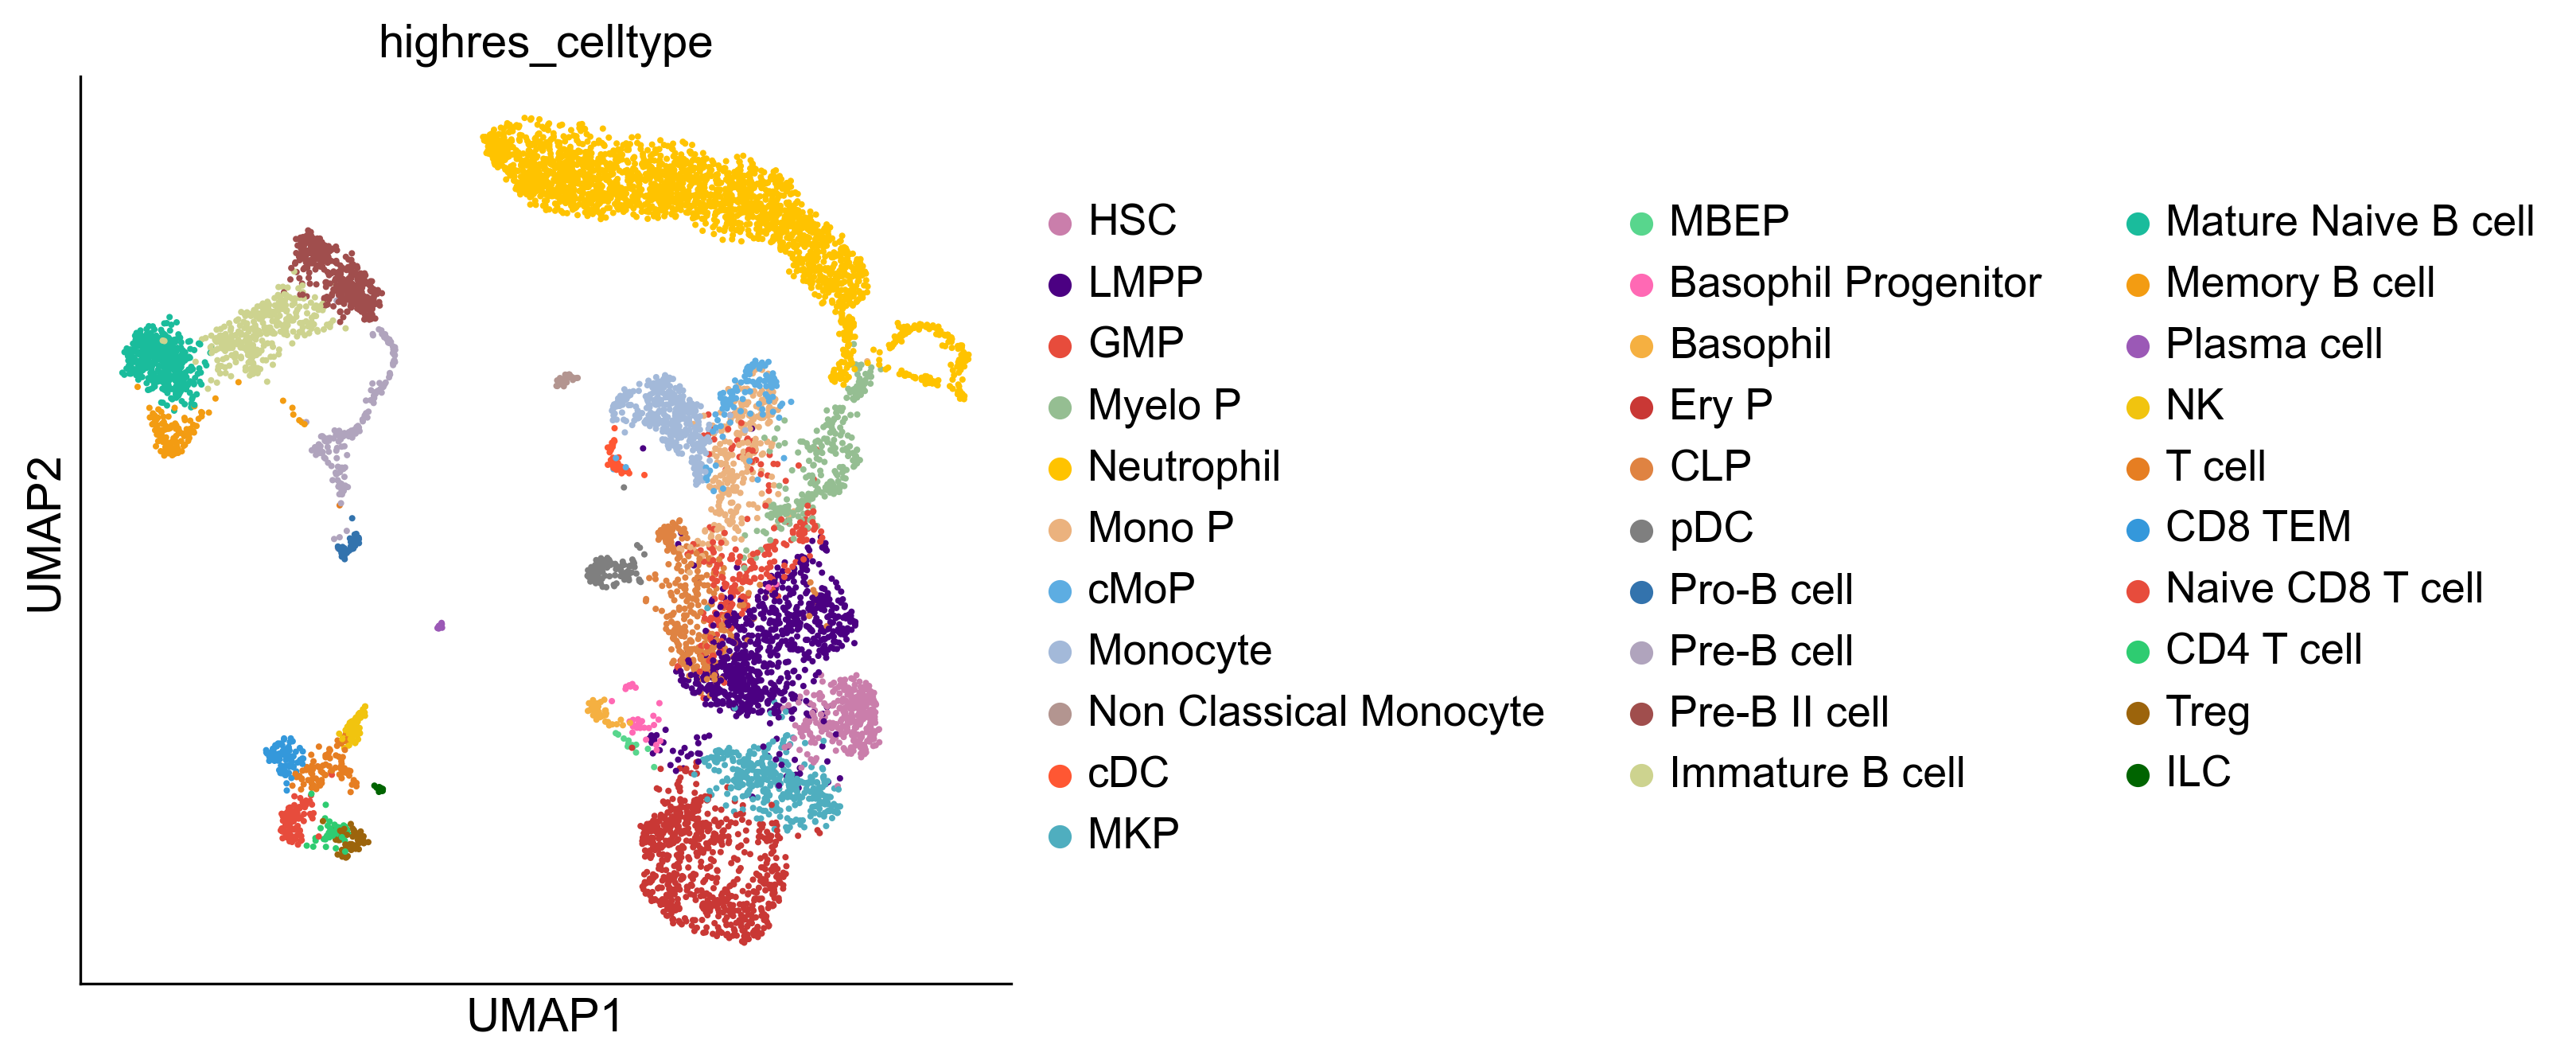

In [5]:
sc.pl.umap(adata, color=CELL_TYPE_COLUMN)

In [6]:
palantir.utils.run_diffusion_maps(adata, pca_key="X_pca_harmony", n_components=40);

## Running Differential Analysis with Kompot

In [7]:
# First, let's compute differential abundance between conditions
da_results = kompot.compute_differential_abundance(
    adata,  # AnnData object
    groupby=GROUPING_COLUMN,  # Column with condition labels
    condition1=CONDITIONS[0],  # Reference condition
    condition2=CONDITIONS[1],  # Comparison condition
    obsm_key=DIMENSIONALITY_REDUCTION,  # Cell state representation
)

[2025-03-11 15:55:16,946] [WARNING ] Run history at kompot_da.run_history not found.
[2025-03-11 15:55:16,948] [INFO    ] Condition 1 (Young): 2,917 cells
[2025-03-11 15:55:16,949] [INFO    ] Condition 2 (Old): 3,116 cells
[2025-03-11 15:55:16,953] [INFO    ] Fitting density estimator for condition 1...
[2025-03-11 15:55:16,982] [INFO    ] Using non-sparse Gaussian Process since n_landmarks (2,917) >= n_samples (2,917) and rank = 1.0.
[2025-03-11 15:55:16,984] [INFO    ] Computing nearest neighbor distances.
[2025-03-11 15:55:23,152] [INFO    ] Using d=1.7019215067034625.
[2025-03-11 15:55:23,263] [INFO    ] Using covariance function Matern52(ls=0.5133400857448578).
[2025-03-11 15:55:23,264] [INFO    ] Computing Lp.
[2025-03-11 15:55:23,733] [INFO    ] Using rank 2,917 covariance representation.
[2025-03-11 15:55:24,607] [INFO    ] Running inference using advi.
[2025-03-11 15:55:28,906] [INFO    ] Computing predictive function.
[2025-03-11 15:55:29,195] [INFO    ] Fitting density estim

In [8]:
# Now, compute differential expression between the conditions
de_results = kompot.compute_differential_expression(
    adata,  # AnnData object
    groupby=GROUPING_COLUMN,  # Column with condition labels
    condition1=CONDITIONS[0],  # Reference condition
    condition2=CONDITIONS[1],  # Comparison condition
    layer=LAYER_FOR_EXPRESSION,  # Expression data layer
    obsm_key=DIMENSIONALITY_REDUCTION,  # Cell state representation
    differential_abundance_key="kompot_da",  # DA results for weighted log-fold change (optional)
    batch_size=0,  # set to, e.g., 100 to batch cells and genes for lower memory demand
)

[2025-03-11 15:55:38,181] [WARNING ] Run history at kompot_de.run_history not found.
[2025-03-11 15:55:38,182] [WARNING ] Run history at kompot_de.run_history not found.
[2025-03-11 15:55:38,183] [INFO    ] Condition 1 (Young): 2,917 cells
[2025-03-11 15:55:38,183] [INFO    ] Condition 2 (Old): 3,116 cells
[2025-03-11 15:55:38,242] [INFO    ] Computing 5,000 landmarks with k-means clustering (random_state=None).
[2025-03-11 15:57:09,479] [INFO    ] Fitting expression estimator for condition 1...
[2025-03-11 15:57:09,481] [INFO    ] Gaussian Process type: fixed
[2025-03-11 15:57:09,580] [INFO    ] Computing nearest neighbor distances.
[2025-03-11 15:57:09,622] [INFO    ] Using covariance function Matern52(ls=0.5133400857448578).
[2025-03-11 15:57:14,942] [INFO    ] Sigma interpreted as element-wise standard deviation.
[2025-03-11 15:57:40,512] [INFO    ] Fitting expression estimator for condition 2...
[2025-03-11 15:57:40,513] [INFO    ] Gaussian Process type: fixed
[2025-03-11 15:57:40

# Computation including Sample Variance

In [9]:
# First, let's compute differential abundance between conditions
da_results = kompot.compute_differential_abundance(
    adata,  # AnnData object
    groupby=GROUPING_COLUMN,  # Column with condition labels
    condition1=CONDITIONS[0],  # Reference condition
    condition2=CONDITIONS[1],  # Comparison condition
    obsm_key=DIMENSIONALITY_REDUCTION,  # Cell state representation
    sample_col="Replicate",
)

[2025-03-11 15:59:13,018] [WARNING ] Results with result_key='kompot_da' already exist in the dataset. Previous run was at 2025-03-11T15:55:38.162467 comparing Young vs Old. Fields that will be overwritten: obs:kompot_da_log_fold_change_Young_vs_Old, obs:kompot_da_log_density_Young. Note: Only fields NOT affected by sample variance (like log_fold_change, log_density) will be overwritten since they don't use the sample variance suffix. These results will likely be identical if other parameters haven't changed. Results will be overwritten.
[2025-03-11 15:59:13,021] [INFO    ] Condition 1 (Young): 2,917 cells
[2025-03-11 15:59:13,022] [INFO    ] Condition 2 (Old): 3,116 cells
[2025-03-11 15:59:13,027] [INFO    ] Using sample column 'Replicate' for sample variance estimation
[2025-03-11 15:59:13,028] [INFO    ] Found 3 unique sample(s) in condition 1
[2025-03-11 15:59:13,030] [INFO    ] Found 3 unique sample(s) in condition 2
[2025-03-11 15:59:13,031] [INFO    ] Fitting density estimator f

Since the sample variance produces a different covariance matrix for each gene, we have to repeat the Cholesky decomposition for each gene too. To avoid memory isses storing the cell x cell x gene matrix, and runtime dong the gene-wise Cholesky decomposition, we limit this analysis to the top 100 genes:

In [10]:
# Now, compute differential expression between the conditions
topn = 100
de_results = kompot.compute_differential_expression(
    adata,  # AnnData object
    groupby=GROUPING_COLUMN,  # Column with condition labels
    condition1=CONDITIONS[0],  # Reference condition
    condition2=CONDITIONS[1],  # Comparison condition
    layer=LAYER_FOR_EXPRESSION,  # Expression data layer
    obsm_key=DIMENSIONALITY_REDUCTION,  # Cell state representation
    differential_abundance_key="kompot_da",  # DA results for weighted log-fold change (optional)
    batch_size=0,  # set to, e.g., 100 to batch cells and genes for lower memory demand
    sample_col="Replicate",
    genes=adata.var.sort_values("kompot_de_mahalanobis_Young_vs_Old", ascending=False)
    .head(topn)
    .index,
)

[2025-03-11 16:00:58,370] [WARNING ] Differential expression results with result_key='kompot_de' already exist in the dataset. Previous run was at 2025-03-11T15:59:12.977286 comparing Young vs Old. Fields that will be overwritten: var:kompot_de_mean_lfc_Young_vs_Old, var:kompot_de_bidirectionality_Young_vs_Old, layers:kompot_de_imputed_Young, layers:kompot_de_fold_change_Young_vs_Old. Note: Only fields NOT affected by sample variance (like mean_log_fold_change, bidirectionality, imputed data, fold_change) will be overwritten since they don't use the sample variance suffix. These results will likely be identical if other parameters haven't changed. Results will be overwritten.
[2025-03-11 16:00:58,371] [INFO    ] Condition 1 (Young): 2,917 cells
[2025-03-11 16:00:58,372] [INFO    ] Condition 2 (Old): 3,116 cells
[2025-03-11 16:00:58,479] [INFO    ] Using sample column 'Replicate' for sample variance estimation
[2025-03-11 16:00:58,480] [INFO    ] Found 3 unique sample(s) in condition 1


Computing gene-specific Mahalanobis distances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:18<00:00,  1.27it/s]

[2025-03-11 16:04:24,975] [INFO    ] Successfully computed Mahalanobis distances for 100 genes using gene-specific covariance


## Visualizing Differential Abundance Results

Now that we've computed differential abundance between conditions, let's visualize the results.

### What to Look For in the Visualizations

1. **Direction of Change**: "up" means a cell state is more abundant in the second condition (Old) compared to the reference (Young), while "down" means less abundant.

2. **Log Fold Change Scale**: 
   - Values near 0 indicate similar abundance across conditions
   - Positive values show enrichment in the second condition (Old)  
   - Negative values show depletion in the second condition (Old)

3. **Spatial Patterns**: Look for regions or clusters in the UMAP showing consistent changes - these represent biologically meaningful shifts.

4. **Cell Type Correlations**: Check if specific cell types are consistently changing in abundance.

The volcano plot displays statistical significance versus effect size, with points above the horizontal line and outside the vertical lines indicating significant changes.

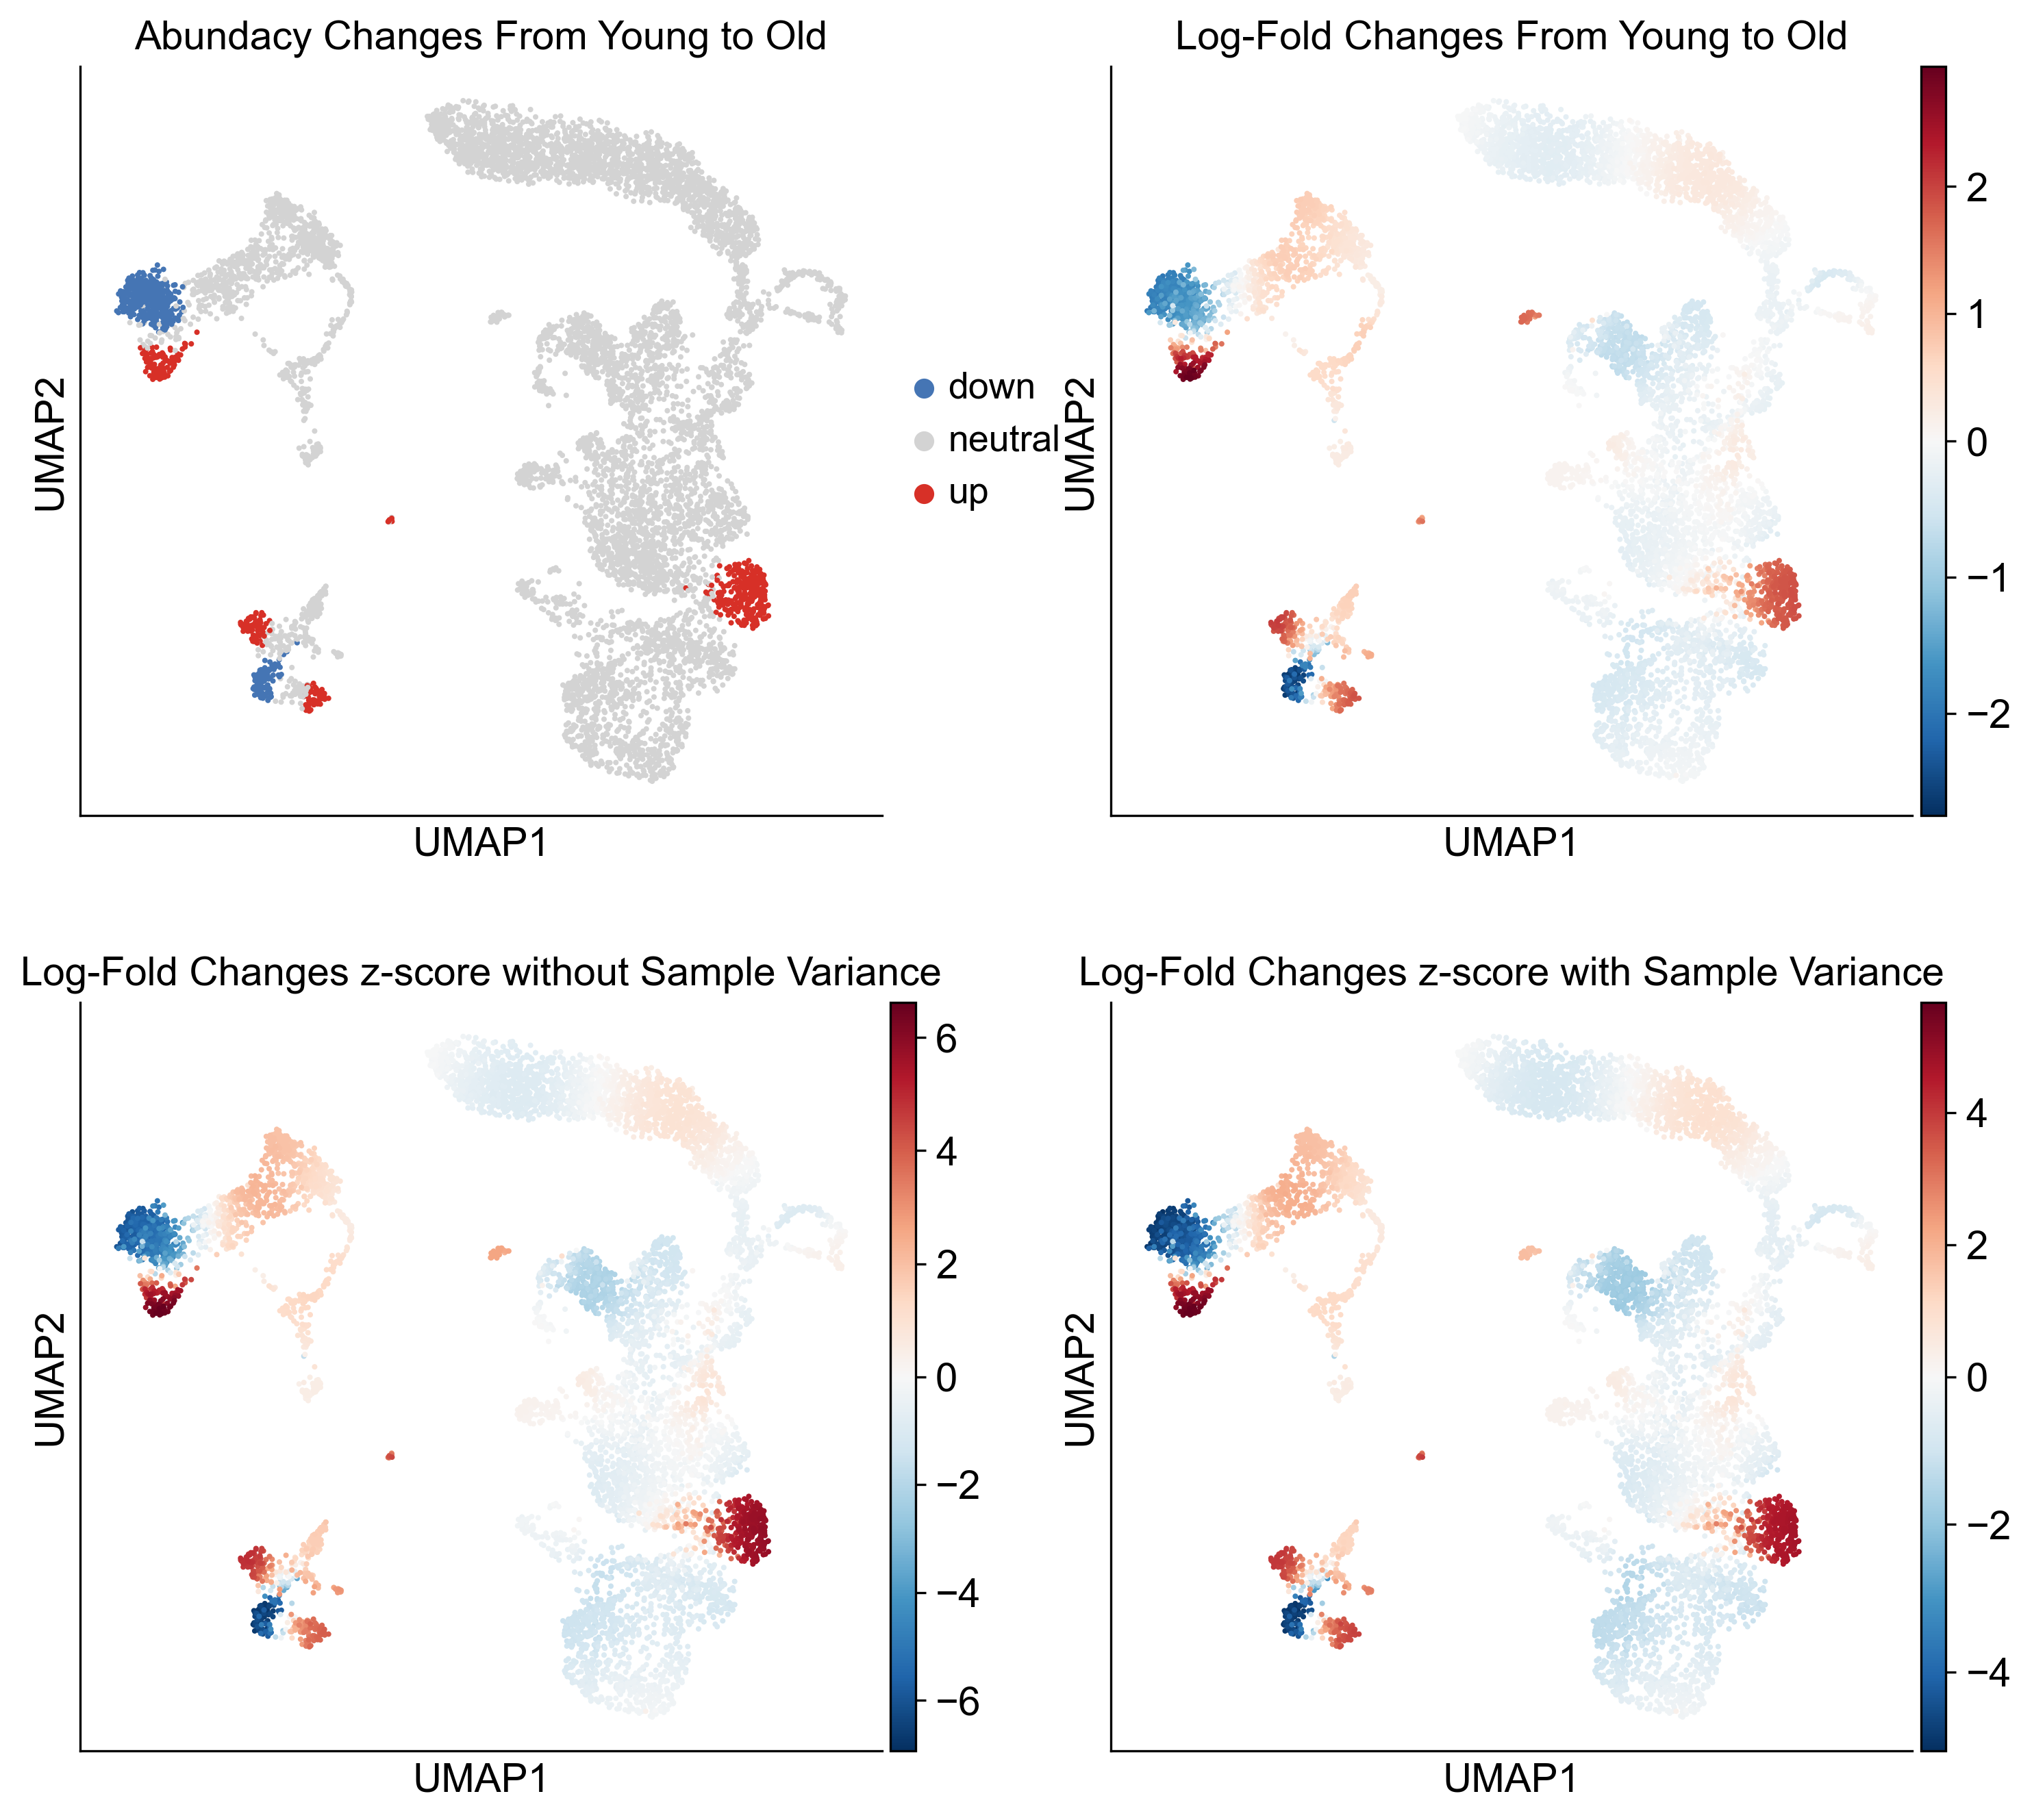

In [11]:
sc.pl.embedding(
    adata,
    "umap",
    color=[
        "kompot_da_log_fold_change_direction_Young_vs_Old",
        "kompot_da_log_fold_change_Young_vs_Old",
        "kompot_da_log_fold_change_zscore_Young_vs_Old",
        "kompot_da_log_fold_change_zscore_Young_vs_Old_sample_var",
    ],
    title=[
        "Abundacy Changes From Young to Old",
        "Log-Fold Changes From Young to Old",
        "Log-Fold Changes z-score without Sample Variance",
        "Log-Fold Changes z-score with Sample Variance",
    ],
    color_map="RdBu_r",
    vcenter=0,
    ncols=2,
)

[2025-03-11 16:04:36,137] [INFO    ] Using DA run 0: comparing Young vs Old
[2025-03-11 16:04:36,137] [INFO    ] Using fields for DA plot - lfc_key: 'kompot_da_log_fold_change_Young_vs_Old', pval_key: 'kompot_da_neg_log10_fold_change_pvalue_Young_vs_Old'
[2025-03-11 16:04:36,138] [INFO    ] Using thresholds - lfc_threshold: 1.0, pval_threshold: 0.05


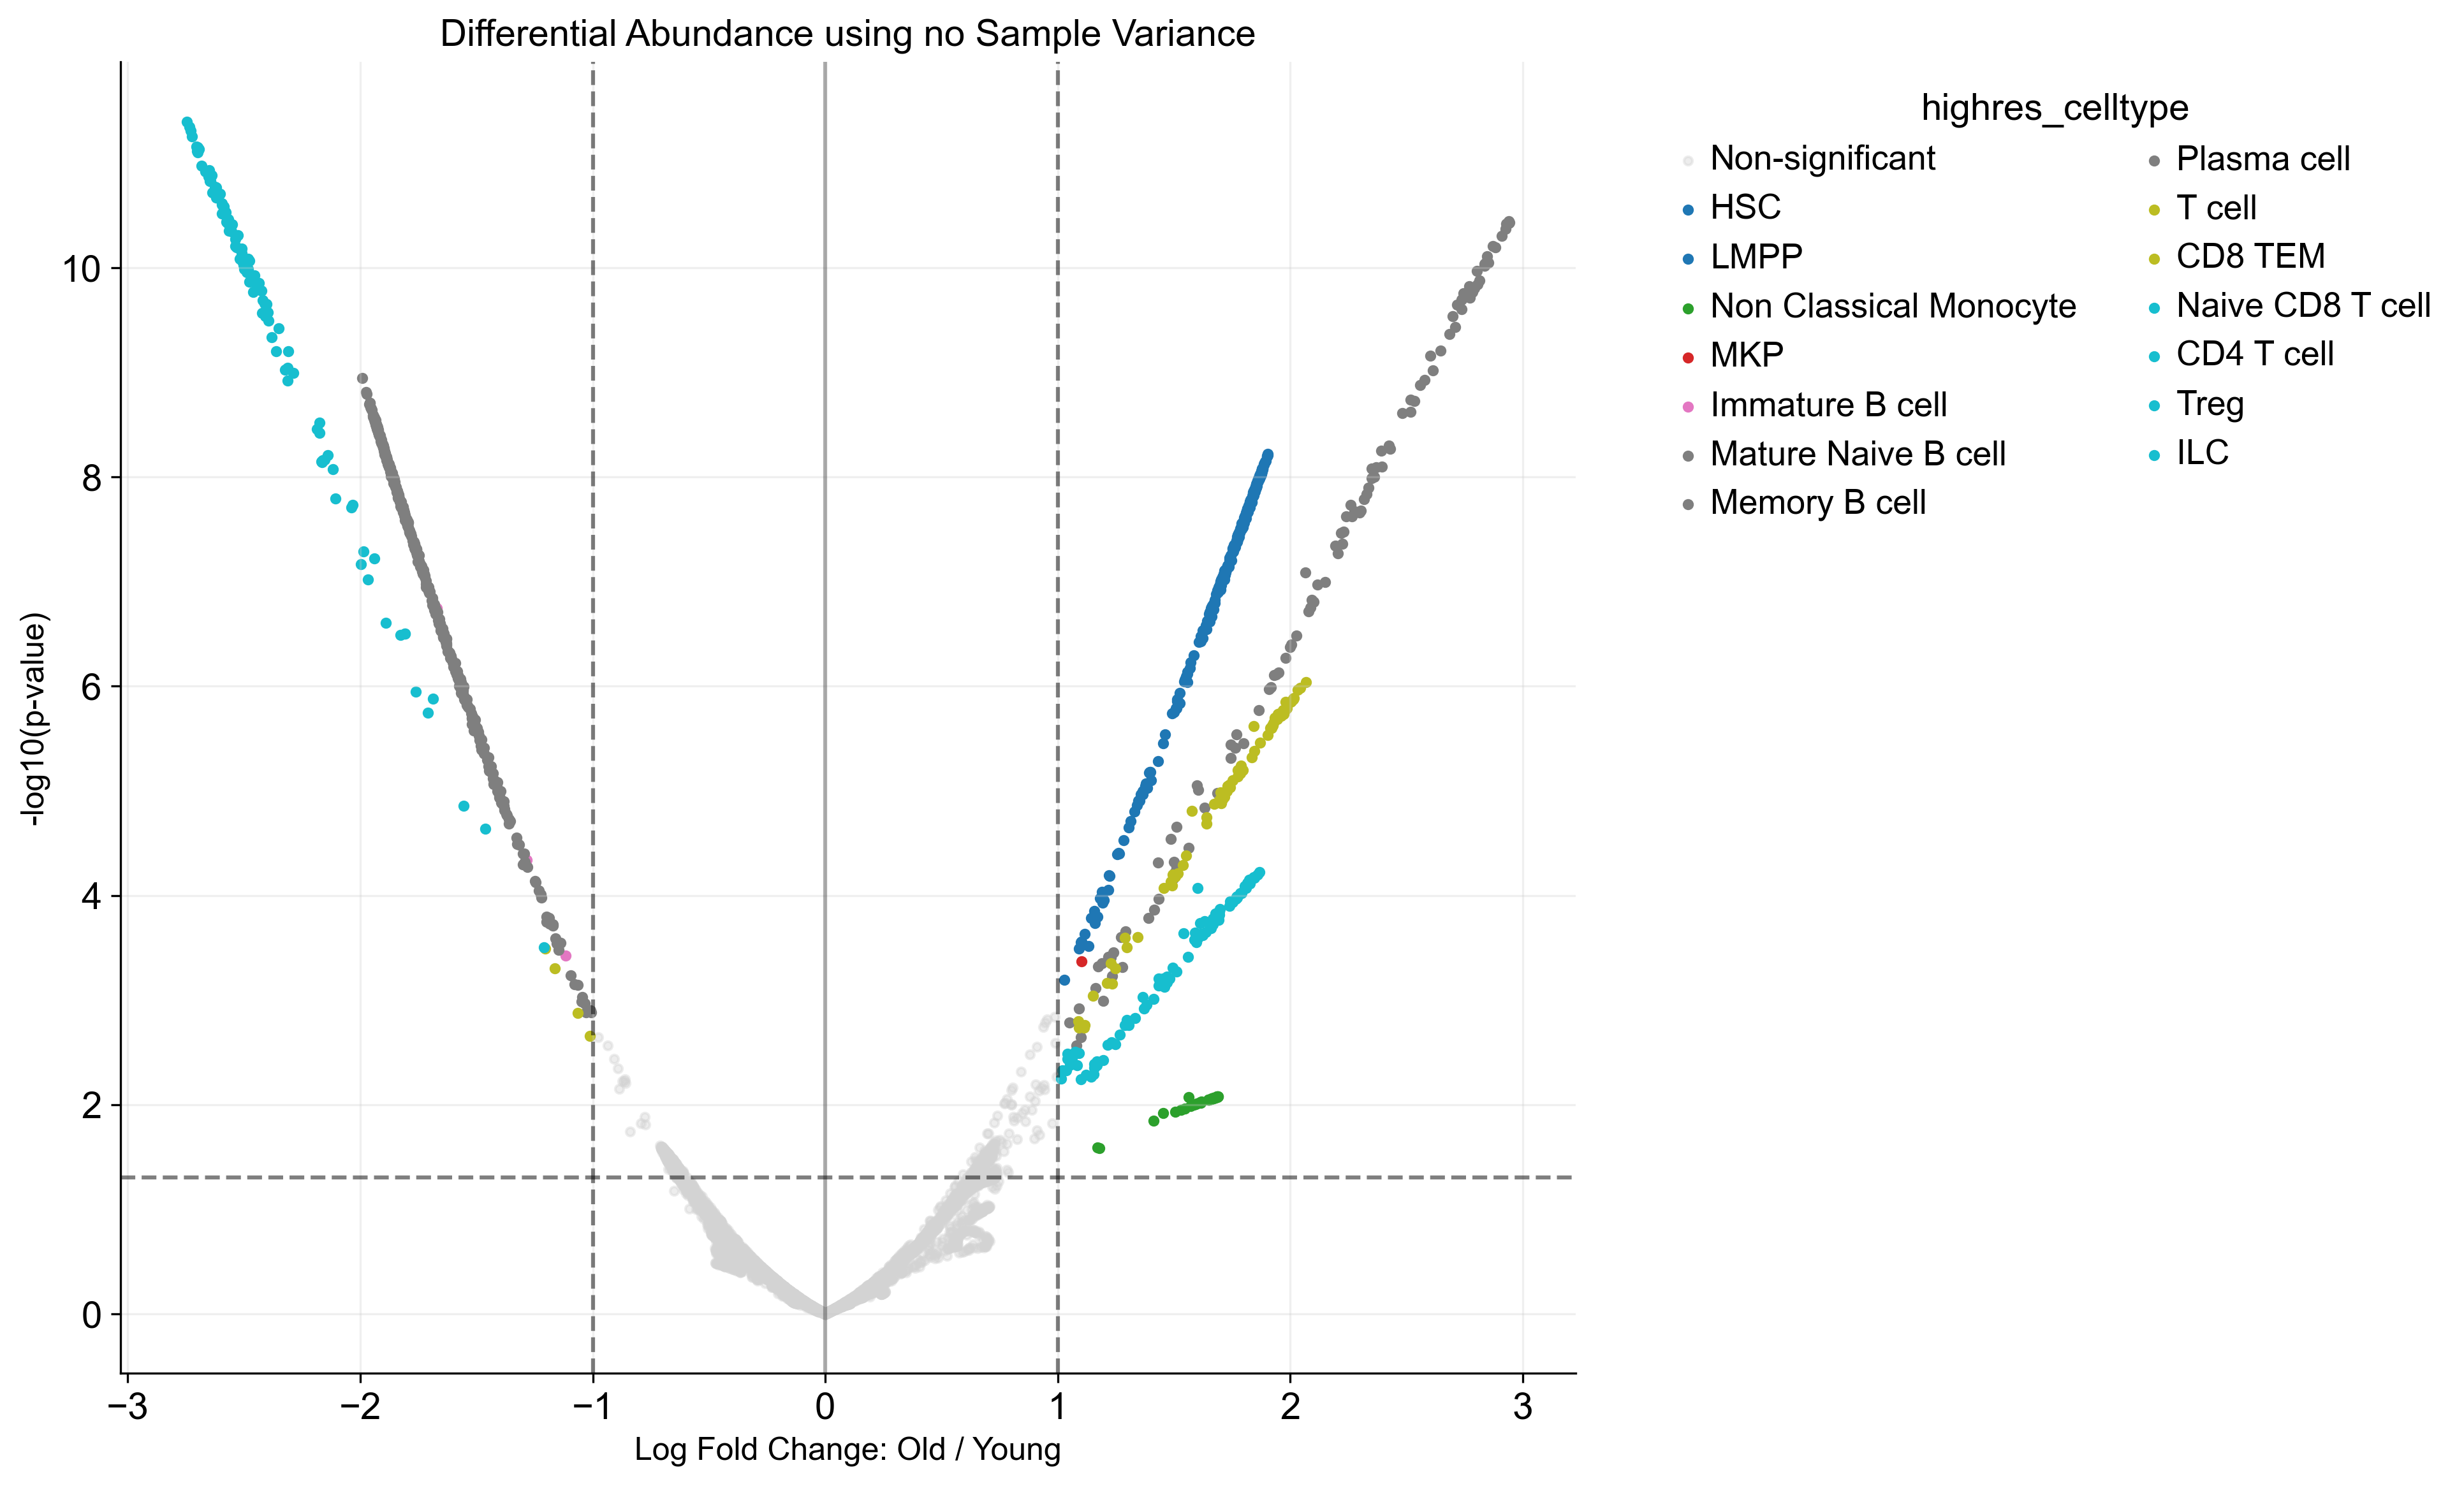

In [12]:
kompot.plot.volcano_da(
    adata,
    color=CELL_TYPE_COLUMN,
    run_id=0,
    title="Differential Abundance using no Sample Variance",
)

[2025-03-11 16:04:36,755] [INFO    ] Using DA run 1: comparing Young vs Old
[2025-03-11 16:04:36,756] [INFO    ] Using fields for DA plot - lfc_key: 'kompot_da_log_fold_change_Young_vs_Old', pval_key: 'kompot_da_neg_log10_fold_change_pvalue_Young_vs_Old_sample_var'
[2025-03-11 16:04:36,756] [INFO    ] Using thresholds - lfc_threshold: 1.0, pval_threshold: 0.05


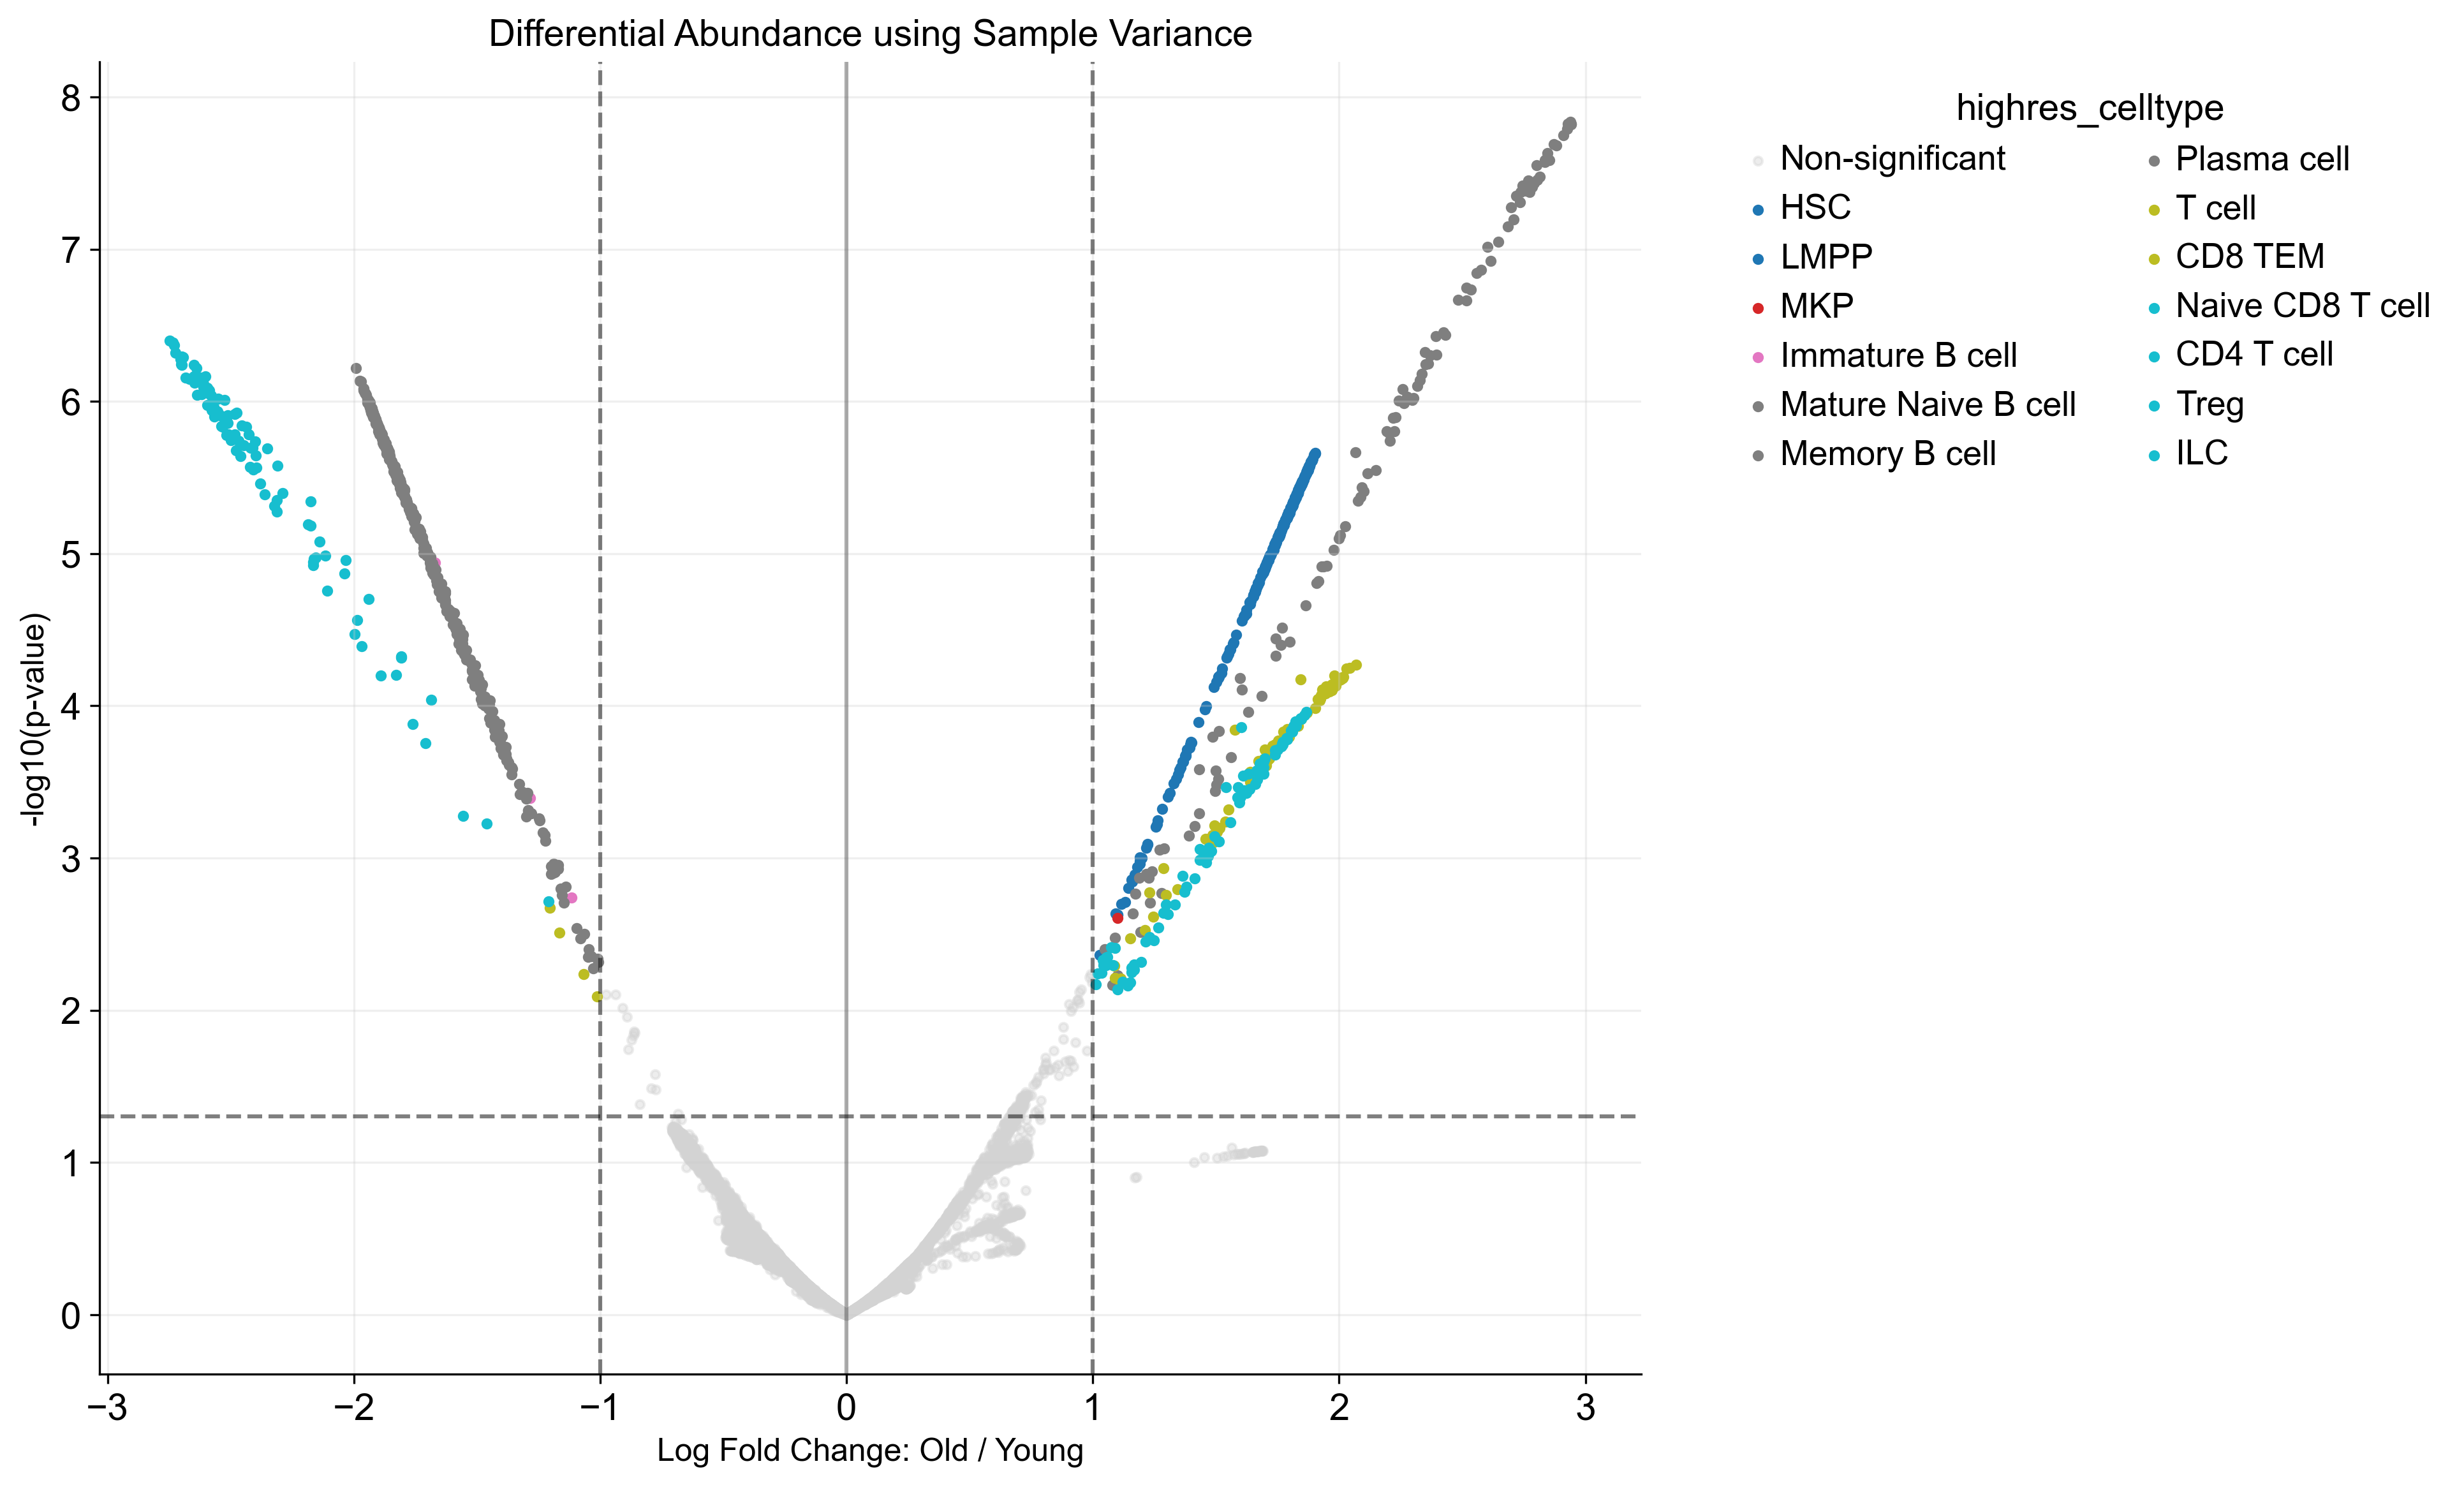

In [13]:
kompot.plot.volcano_da(
    adata,
    color=CELL_TYPE_COLUMN,
    run_id=1,
    title="Differential Abundance using Sample Variance",
)

## Visualizing Differential Expression Results


In [14]:
adata.var[
    ["kompot_de_weighted_lfc_Young_vs_Old", "kompot_de_mahalanobis_Young_vs_Old"]
].sort_values("kompot_de_mahalanobis_Young_vs_Old", ascending=False).head(20)

kompot_de_weighted_lfc_Young_vs_Old  \
H2-Q7                                1.344973   
Cd74                                 0.525005   
H2-Aa                                0.608966   
H2-Ab1                               0.581043   
Igkc                                 0.079981   
H2-Eb1                               0.541995   
AW112010                             0.916825   
S100a9                              -0.464248   
Ifitm3                               0.580449   
S100a8                              -0.461644   
H2-Q6                                0.862108   
Cd52                                -0.410056   
Aldh1a1                              0.599299   
Ifitm1                               0.656616   
Ifitm2                               0.403111   
Ighm                                -0.292361   
Cd79a                                0.024962   
Apoe                                 0.221597   
Fos                                  0.621791   
Gm47283                              0.647201   

          kompot_de_mahalanobis_Young_vs_Old  
H2-Q7                              71.513350  
Cd74                               60.009649  
H2-Aa                              59.363446  
H2-Ab1                             57.802728  
Igkc                               53.590104  
H2-Eb1                             53.395853  
AW112010                           53.380622  
S100a9                             48.752286  
Ifitm3                             47.574401  
S100a8                             47.359853  
H2-Q6                              45.990023  
Cd52                               45.298494  
Aldh1a1                            44.595483  
Ifitm1                             44.309708  
Ifitm2                             43.930045  
Ighm                               43.203827  
Cd79a                              43.093205  
Apoe                               42.927761  
Fos                                42.283972  
Gm47283                            41.956978

[2025-03-11 16:04:37,175] [INFO    ] Using DE run 0: comparing Young vs Old
[2025-03-11 16:04:37,175] [INFO    ] Using fields for DE plot - lfc_key: 'kompot_de_mean_lfc_Young_vs_Old', score_key: 'kompot_de_mahalanobis_Young_vs_Old'


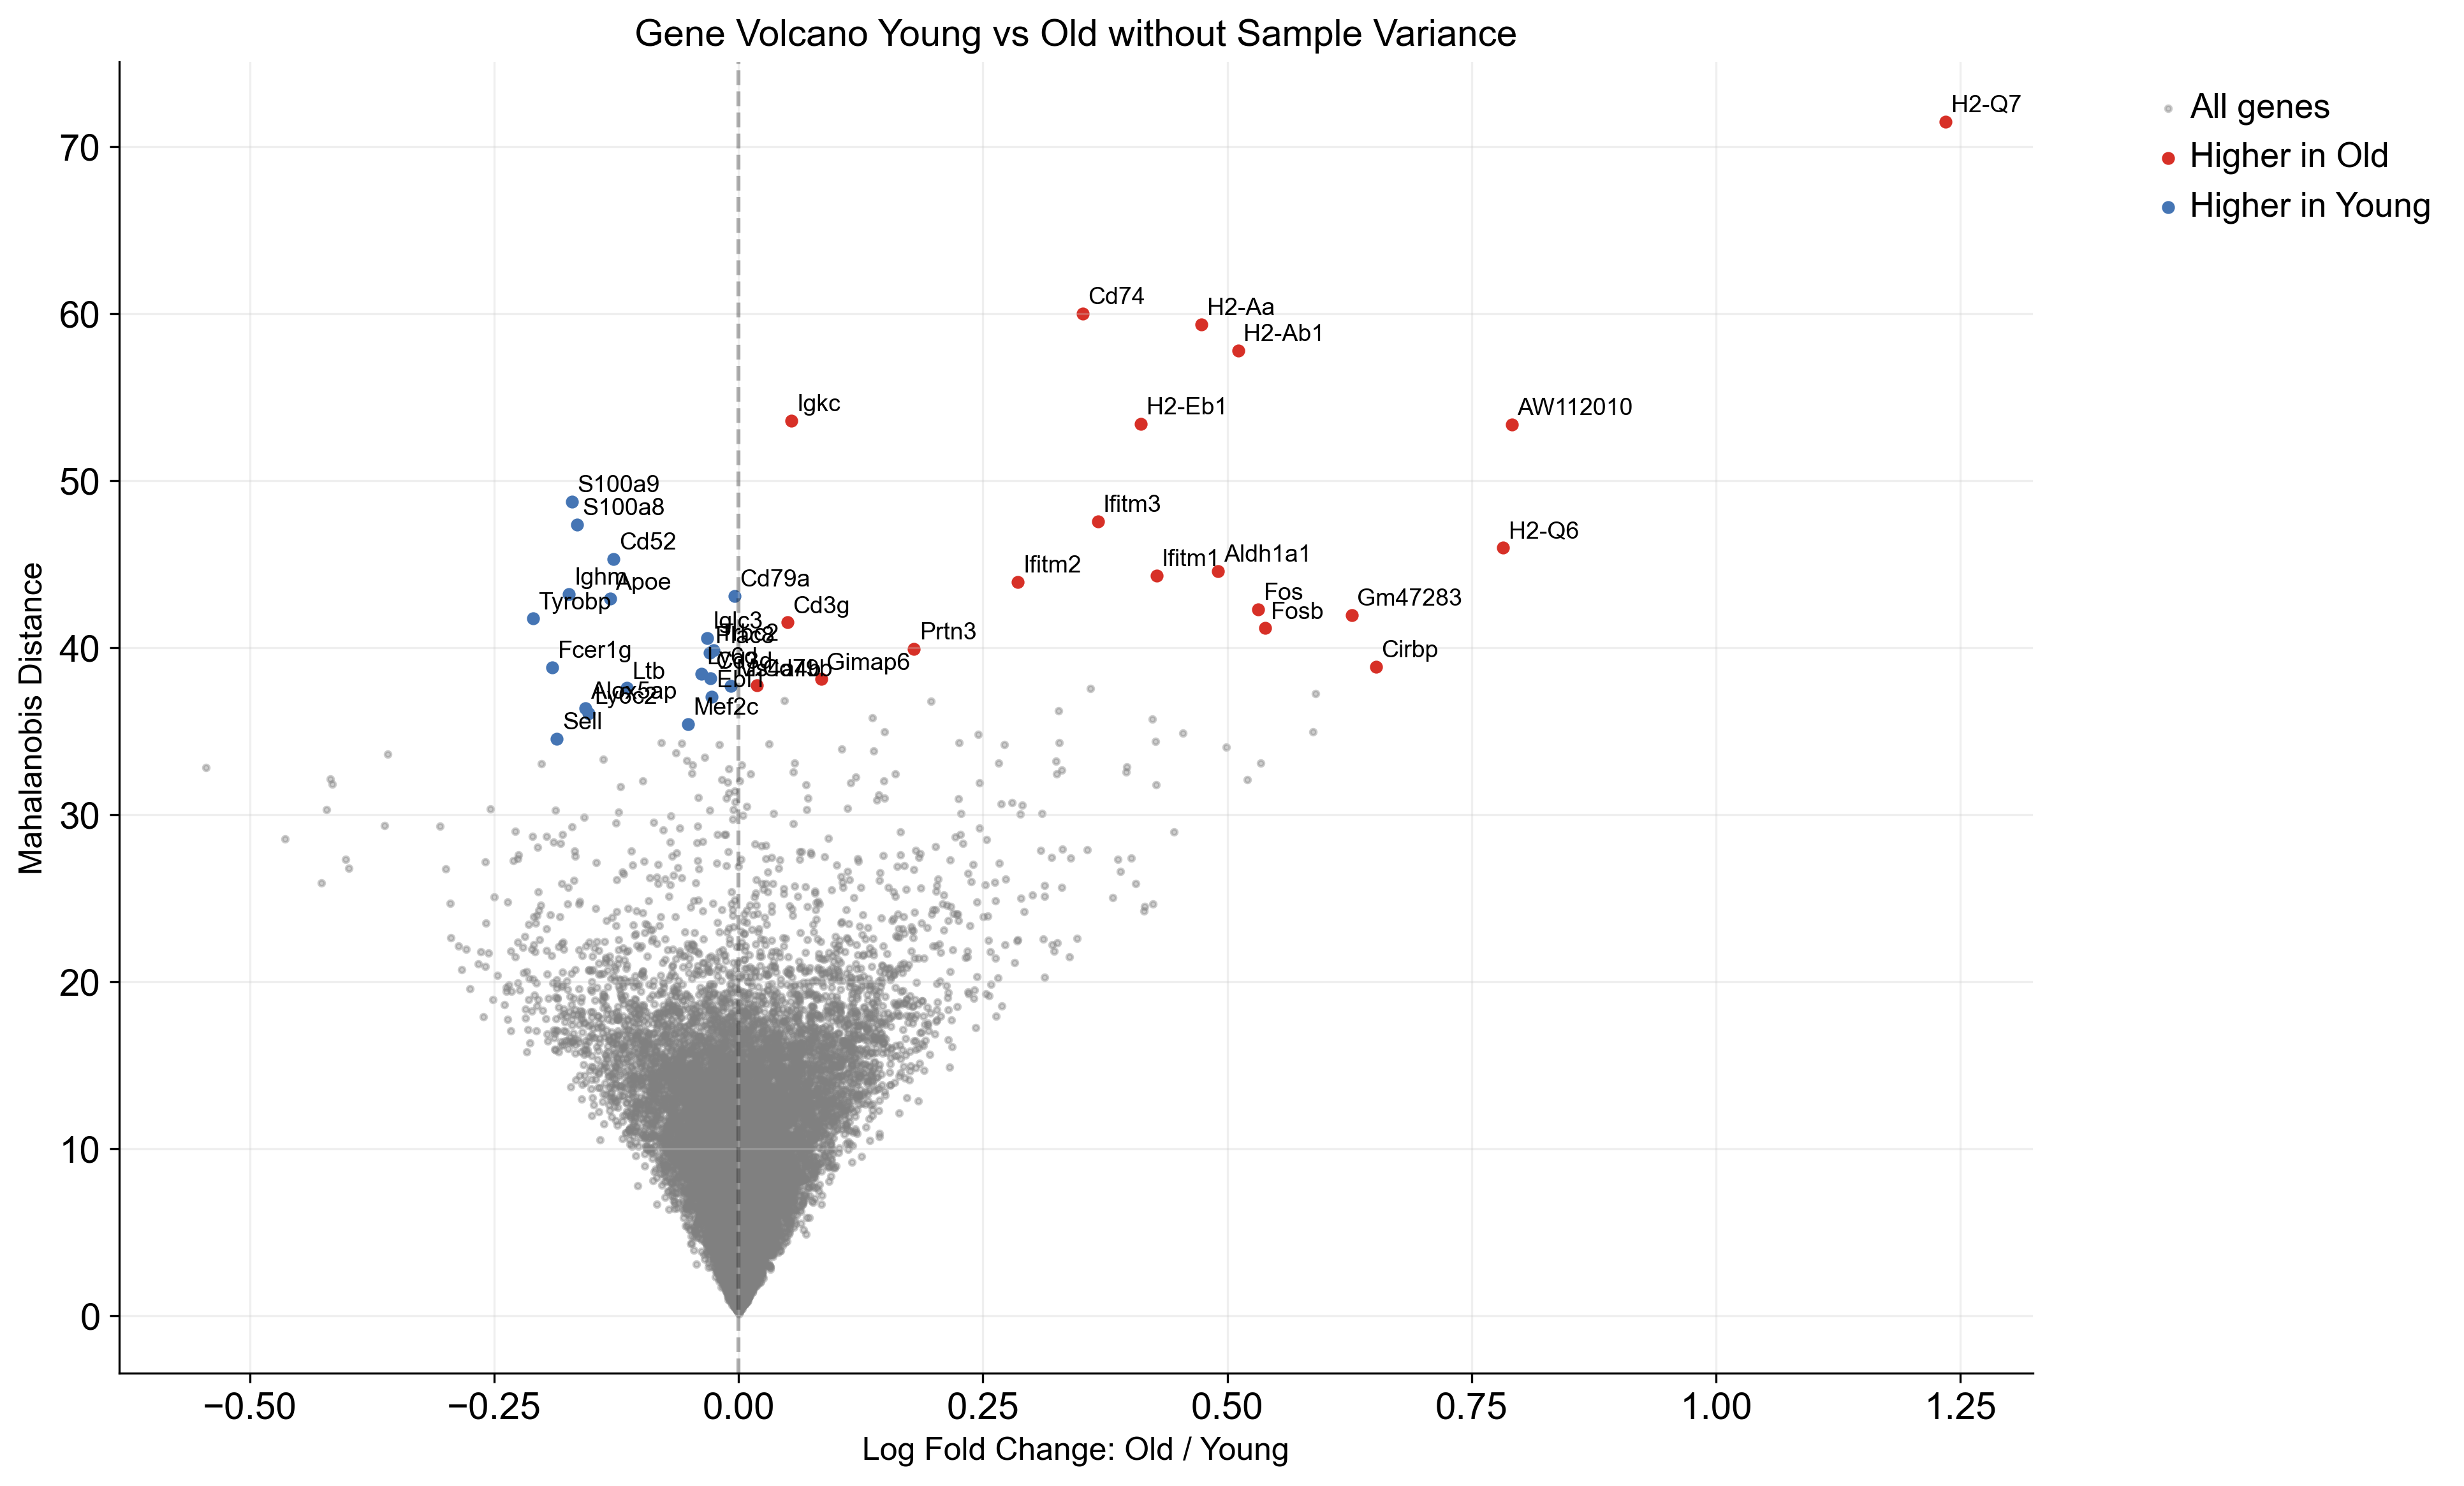

In [15]:
kompot.plot.volcano_de(
    adata,
    n_top_genes=20,
    run_id=0,
    title="Gene Volcano Young vs Old without Sample Variance",
)

Since we only computed this for 100 genes above, this plot is a lot sparser:

[2025-03-11 16:04:37,576] [INFO    ] Using DE run 1: comparing Young vs Old
[2025-03-11 16:04:37,576] [INFO    ] Using fields for DE plot - lfc_key: 'kompot_de_mean_lfc_Young_vs_Old', score_key: 'kompot_de_mahalanobis_Young_vs_Old_sample_var'


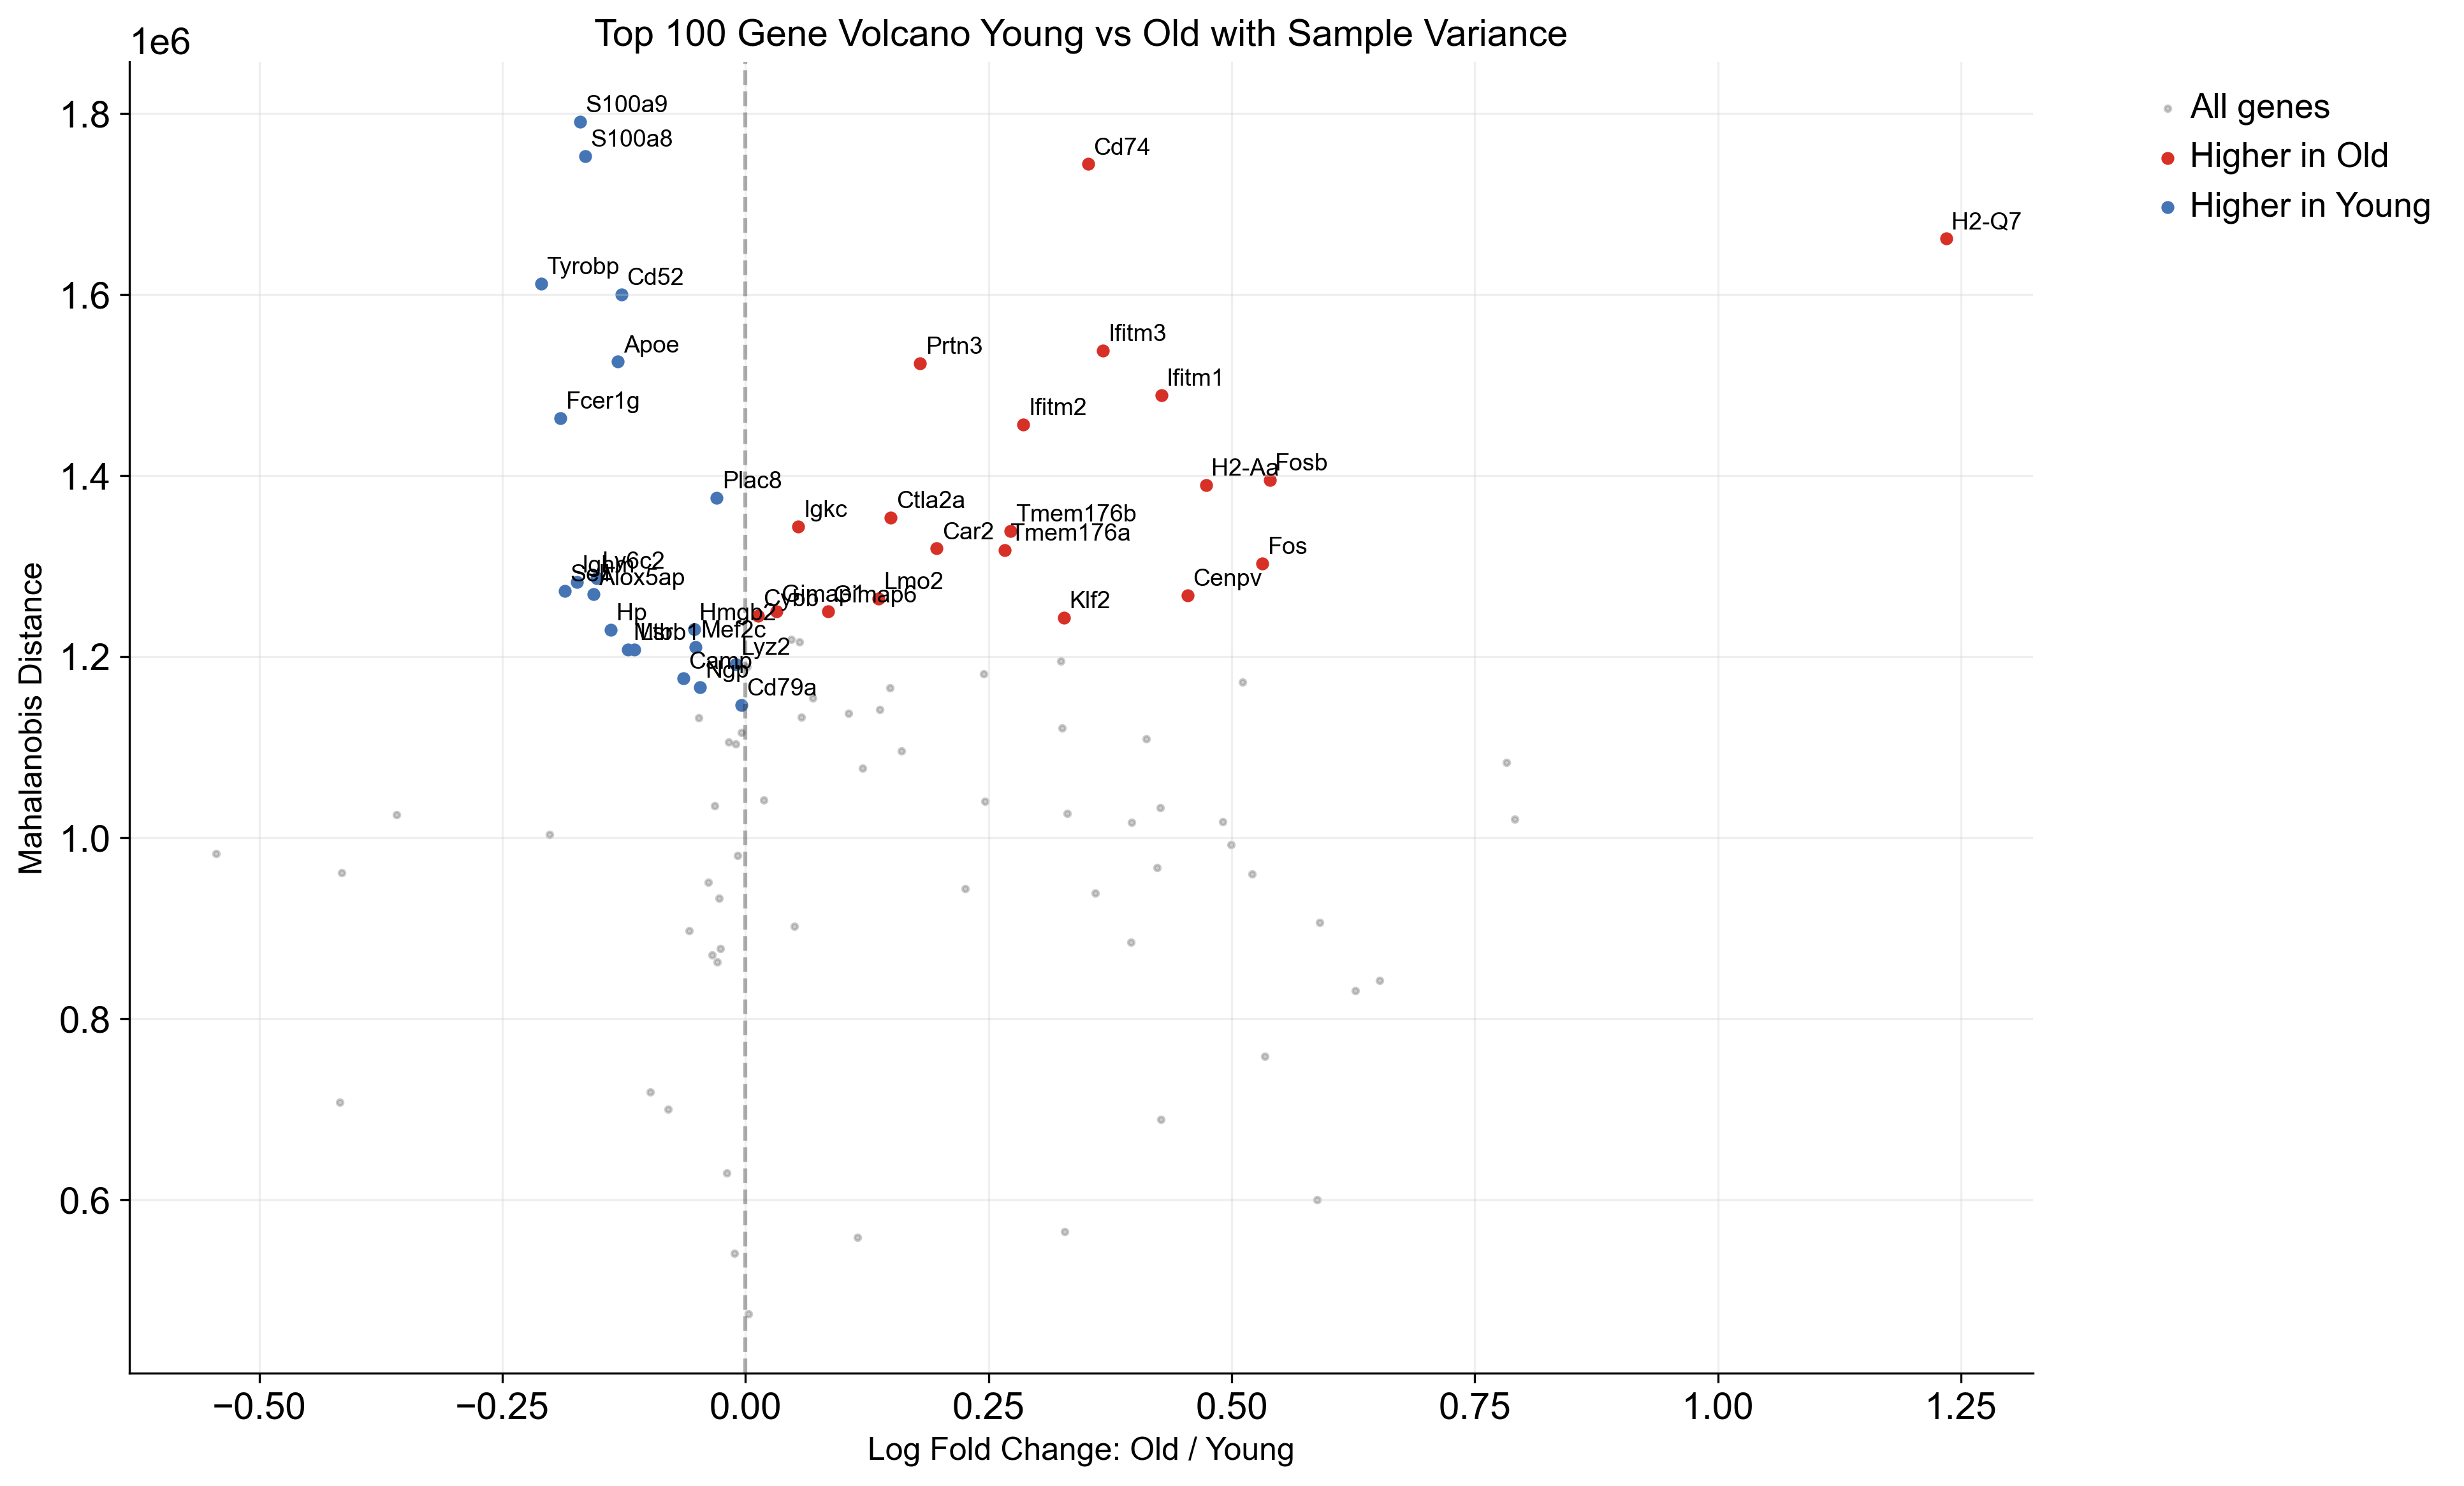

In [16]:
kompot.plot.volcano_de(
    adata,
    n_top_genes=20,
    run_id=1,
    title=f"Top {topn} Gene Volcano Young vs Old with Sample Variance",
)

[2025-03-11 18:12:05,859] [INFO    ] Using DE run 0 for heatmap: comparing Young vs Old
[2025-03-11 18:12:05,859] [INFO    ] Using fields for heatmap - lfc_key: 'kompot_de_mean_lfc_Young_vs_Old', score_key: 'kompot_de_mahalanobis_Young_vs_Old'
[2025-03-11 18:12:05,862] [INFO    ] Using condition_column 'Age' from run information
[2025-03-11 18:12:05,862] [INFO    ] Using DE run 0 for heatmap: comparing Young vs Old
[2025-03-11 18:12:05,863] [INFO    ] Creating split heatmap with 20 genes/features
[2025-03-11 18:12:05,863] [INFO    ] Using expression data from adata.X
[2025-03-11 18:12:05,959] [INFO    ] Excluded 7 cells from groups: Plasma cell
[2025-03-11 18:12:05,962] [INFO    ] Applying gene-wise z-scoring (standard_scale='var')


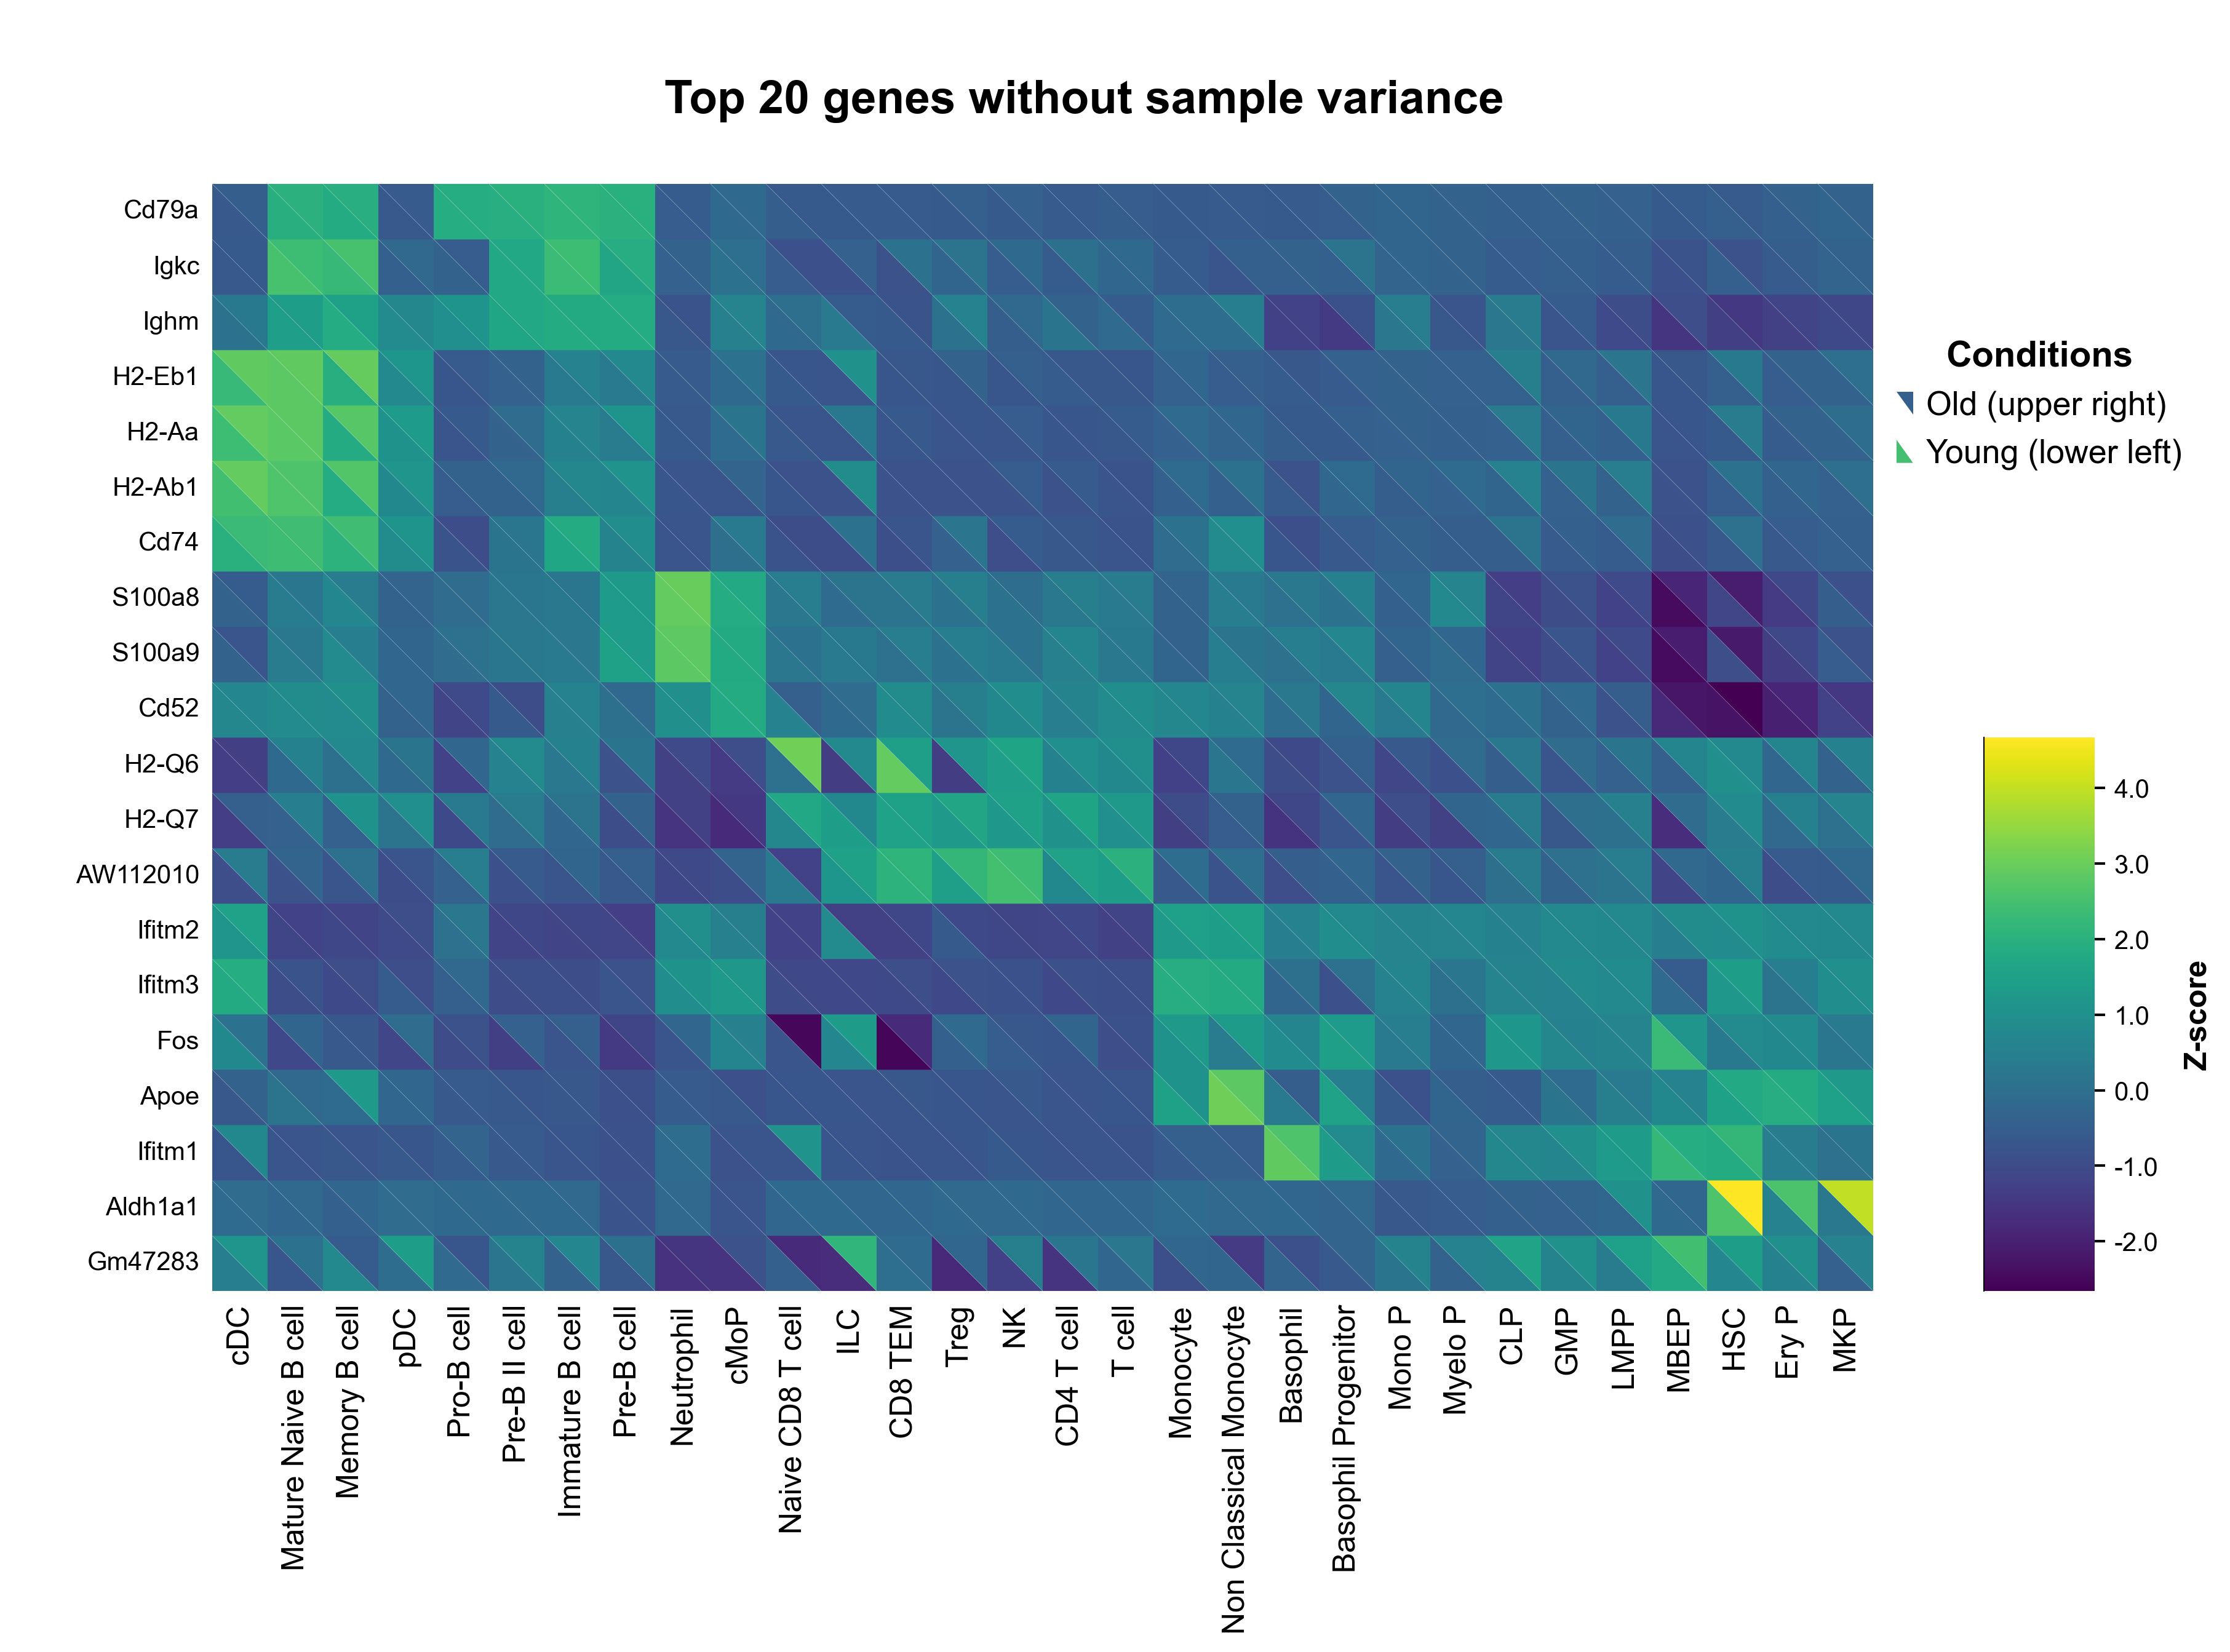

In [147]:
kompot.plot.heatmap(
    adata,
    n_top_genes=20,
    run_id=0,
    groupby=CELL_TYPE_COLUMN,
    exclude_groups="Plasma cell",
    title="Top 20 genes without sample variance",
)

[2025-03-11 18:12:19,879] [INFO    ] Using DE run 1 for heatmap: comparing Young vs Old
[2025-03-11 18:12:19,879] [INFO    ] Using fields for heatmap - lfc_key: 'kompot_de_mean_lfc_Young_vs_Old', score_key: 'kompot_de_mahalanobis_Young_vs_Old_sample_var'
[2025-03-11 18:12:19,882] [INFO    ] Using condition_column 'Age' from run information
[2025-03-11 18:12:19,882] [INFO    ] Using DE run 1 for heatmap: comparing Young vs Old
[2025-03-11 18:12:19,882] [INFO    ] Creating split heatmap with 20 genes/features
[2025-03-11 18:12:19,883] [INFO    ] Using expression data from adata.X
[2025-03-11 18:12:19,983] [INFO    ] Excluded 7 cells from groups: Plasma cell
[2025-03-11 18:12:19,986] [INFO    ] Applying gene-wise z-scoring (standard_scale='var')


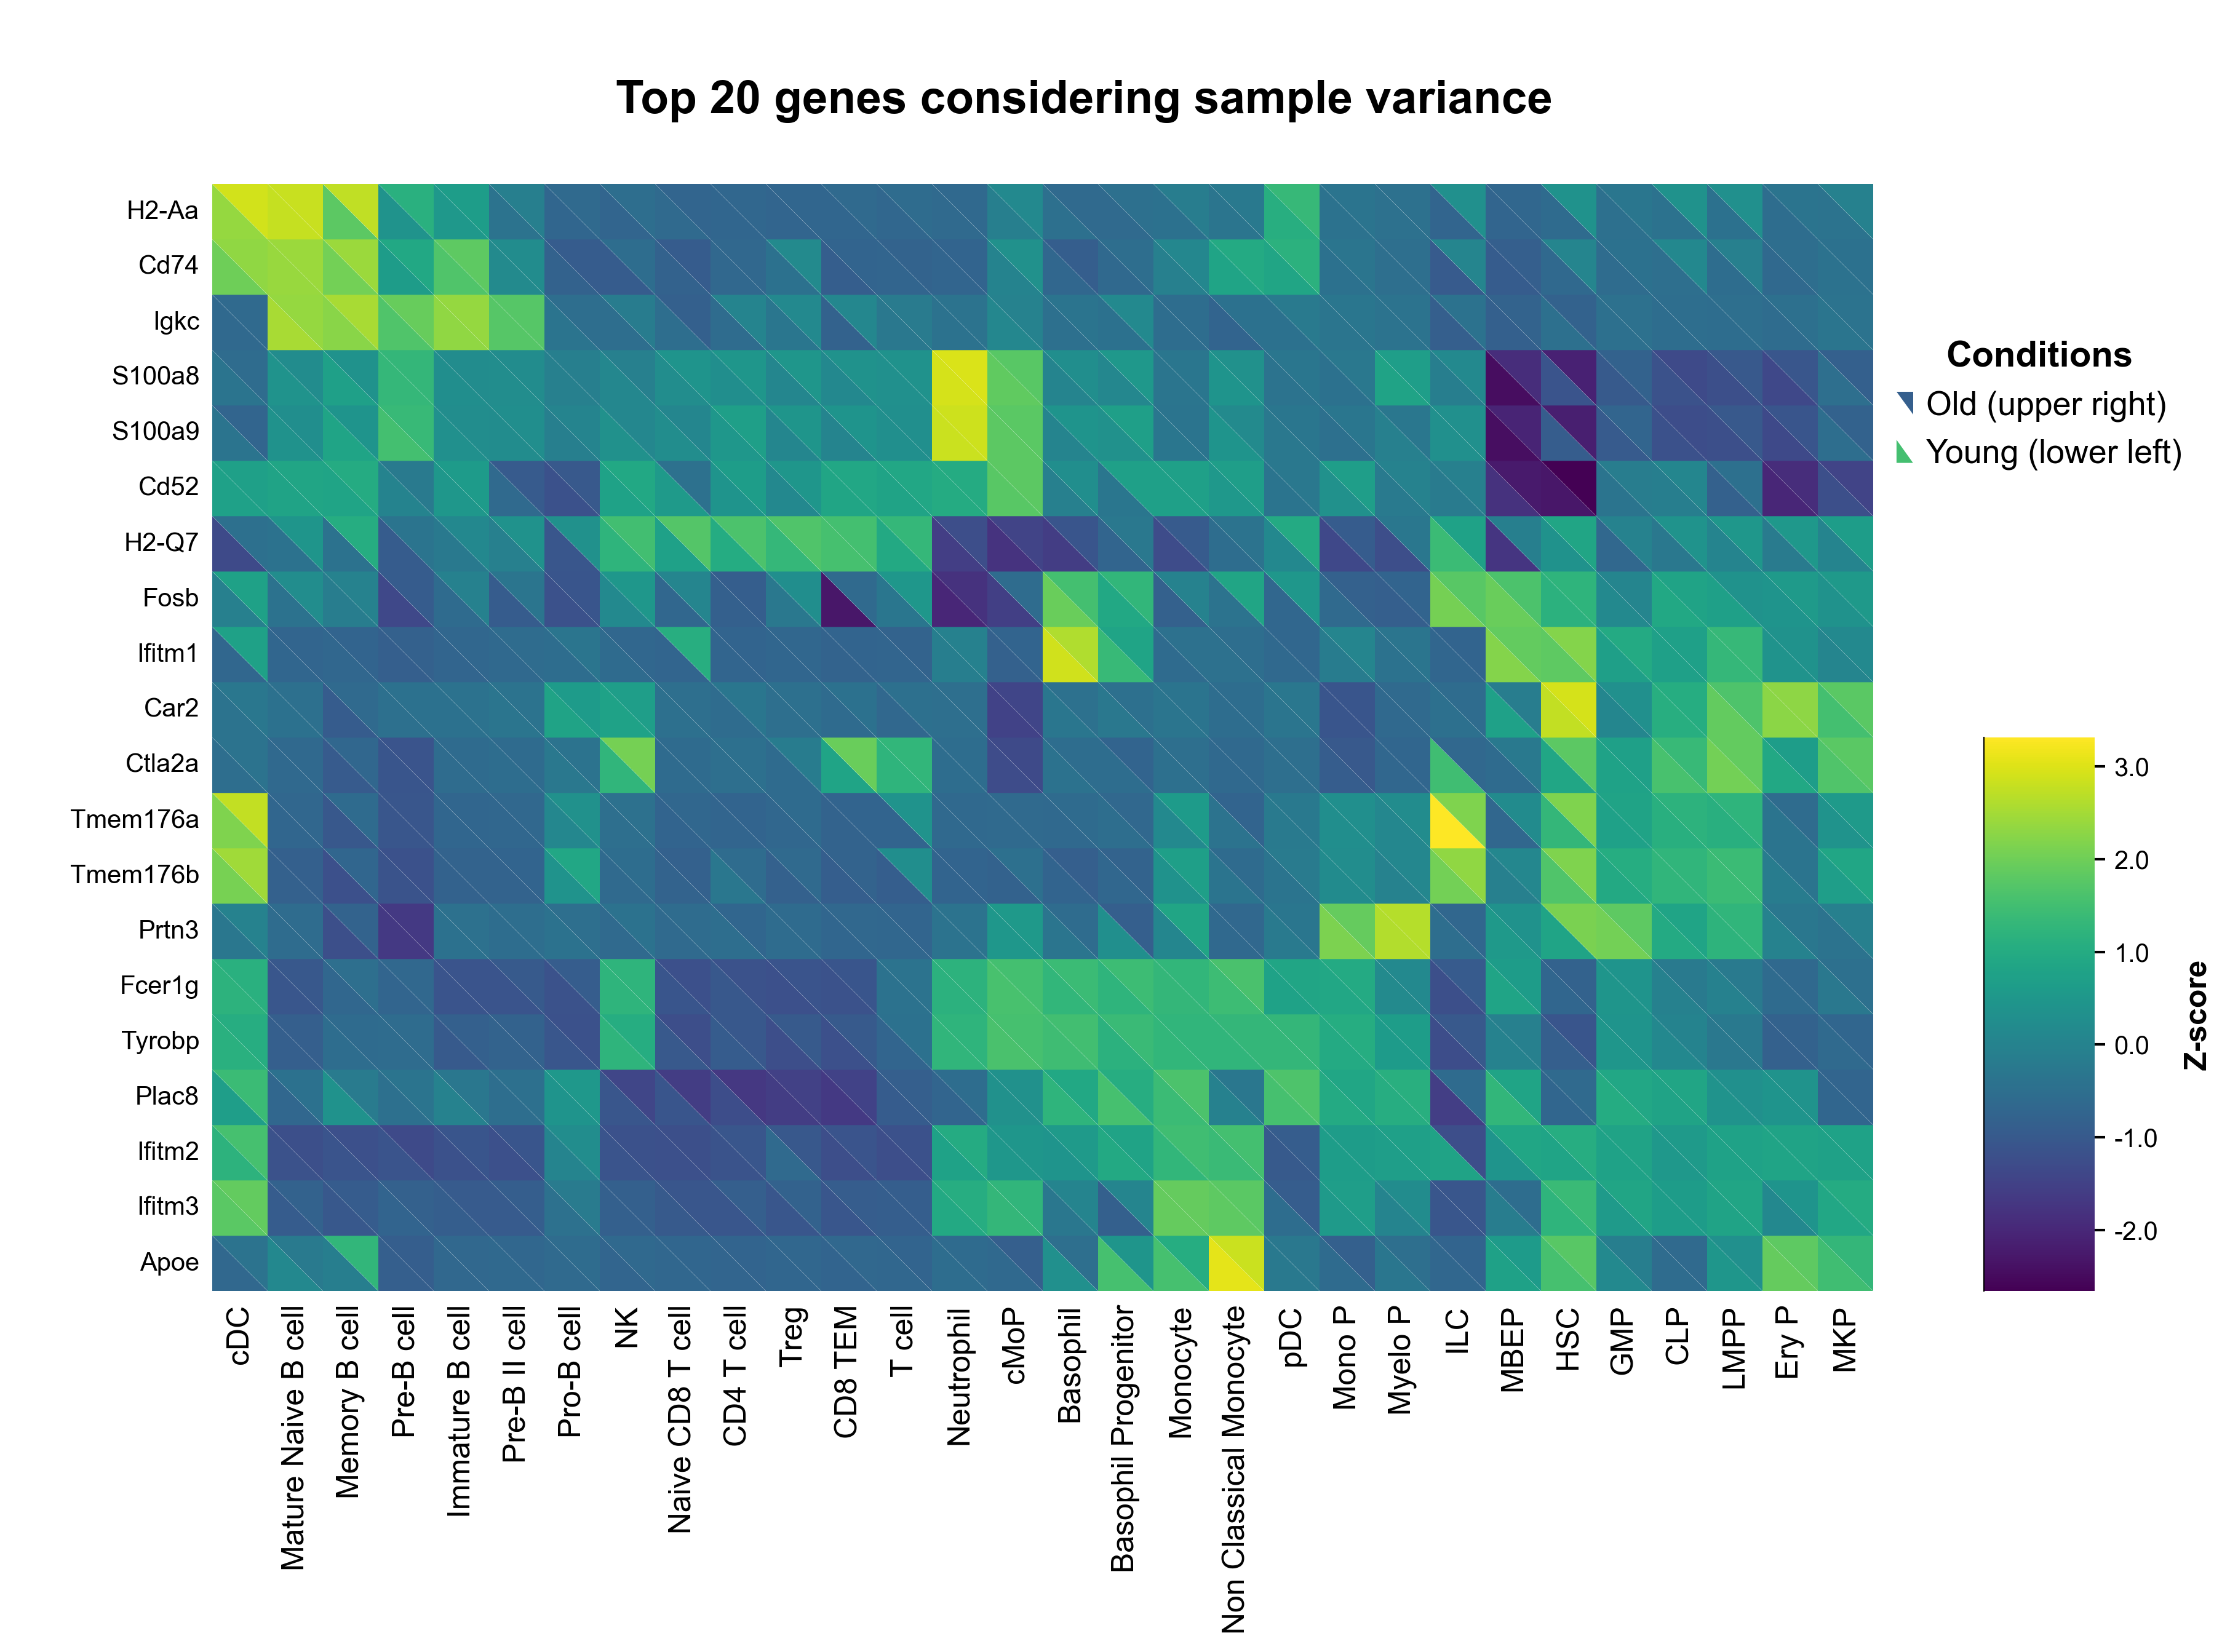

In [148]:
kompot.plot.heatmap(
    adata,
    n_top_genes=20,
    run_id=1,
    groupby=CELL_TYPE_COLUMN,
    exclude_groups="Plasma cell",
    title="Top 20 genes considering sample variance",
)

[2025-03-11 16:04:41,849] [INFO    ] Using DE run 1: comparing Young vs Old
[2025-03-11 16:04:41,849] [INFO    ] Using fields for gene expression plot - lfc_key: 'kompot_de_mean_lfc_Young_vs_Old', score_key: 'kompot_de_mahalanobis_Young_vs_Old_sample_var'


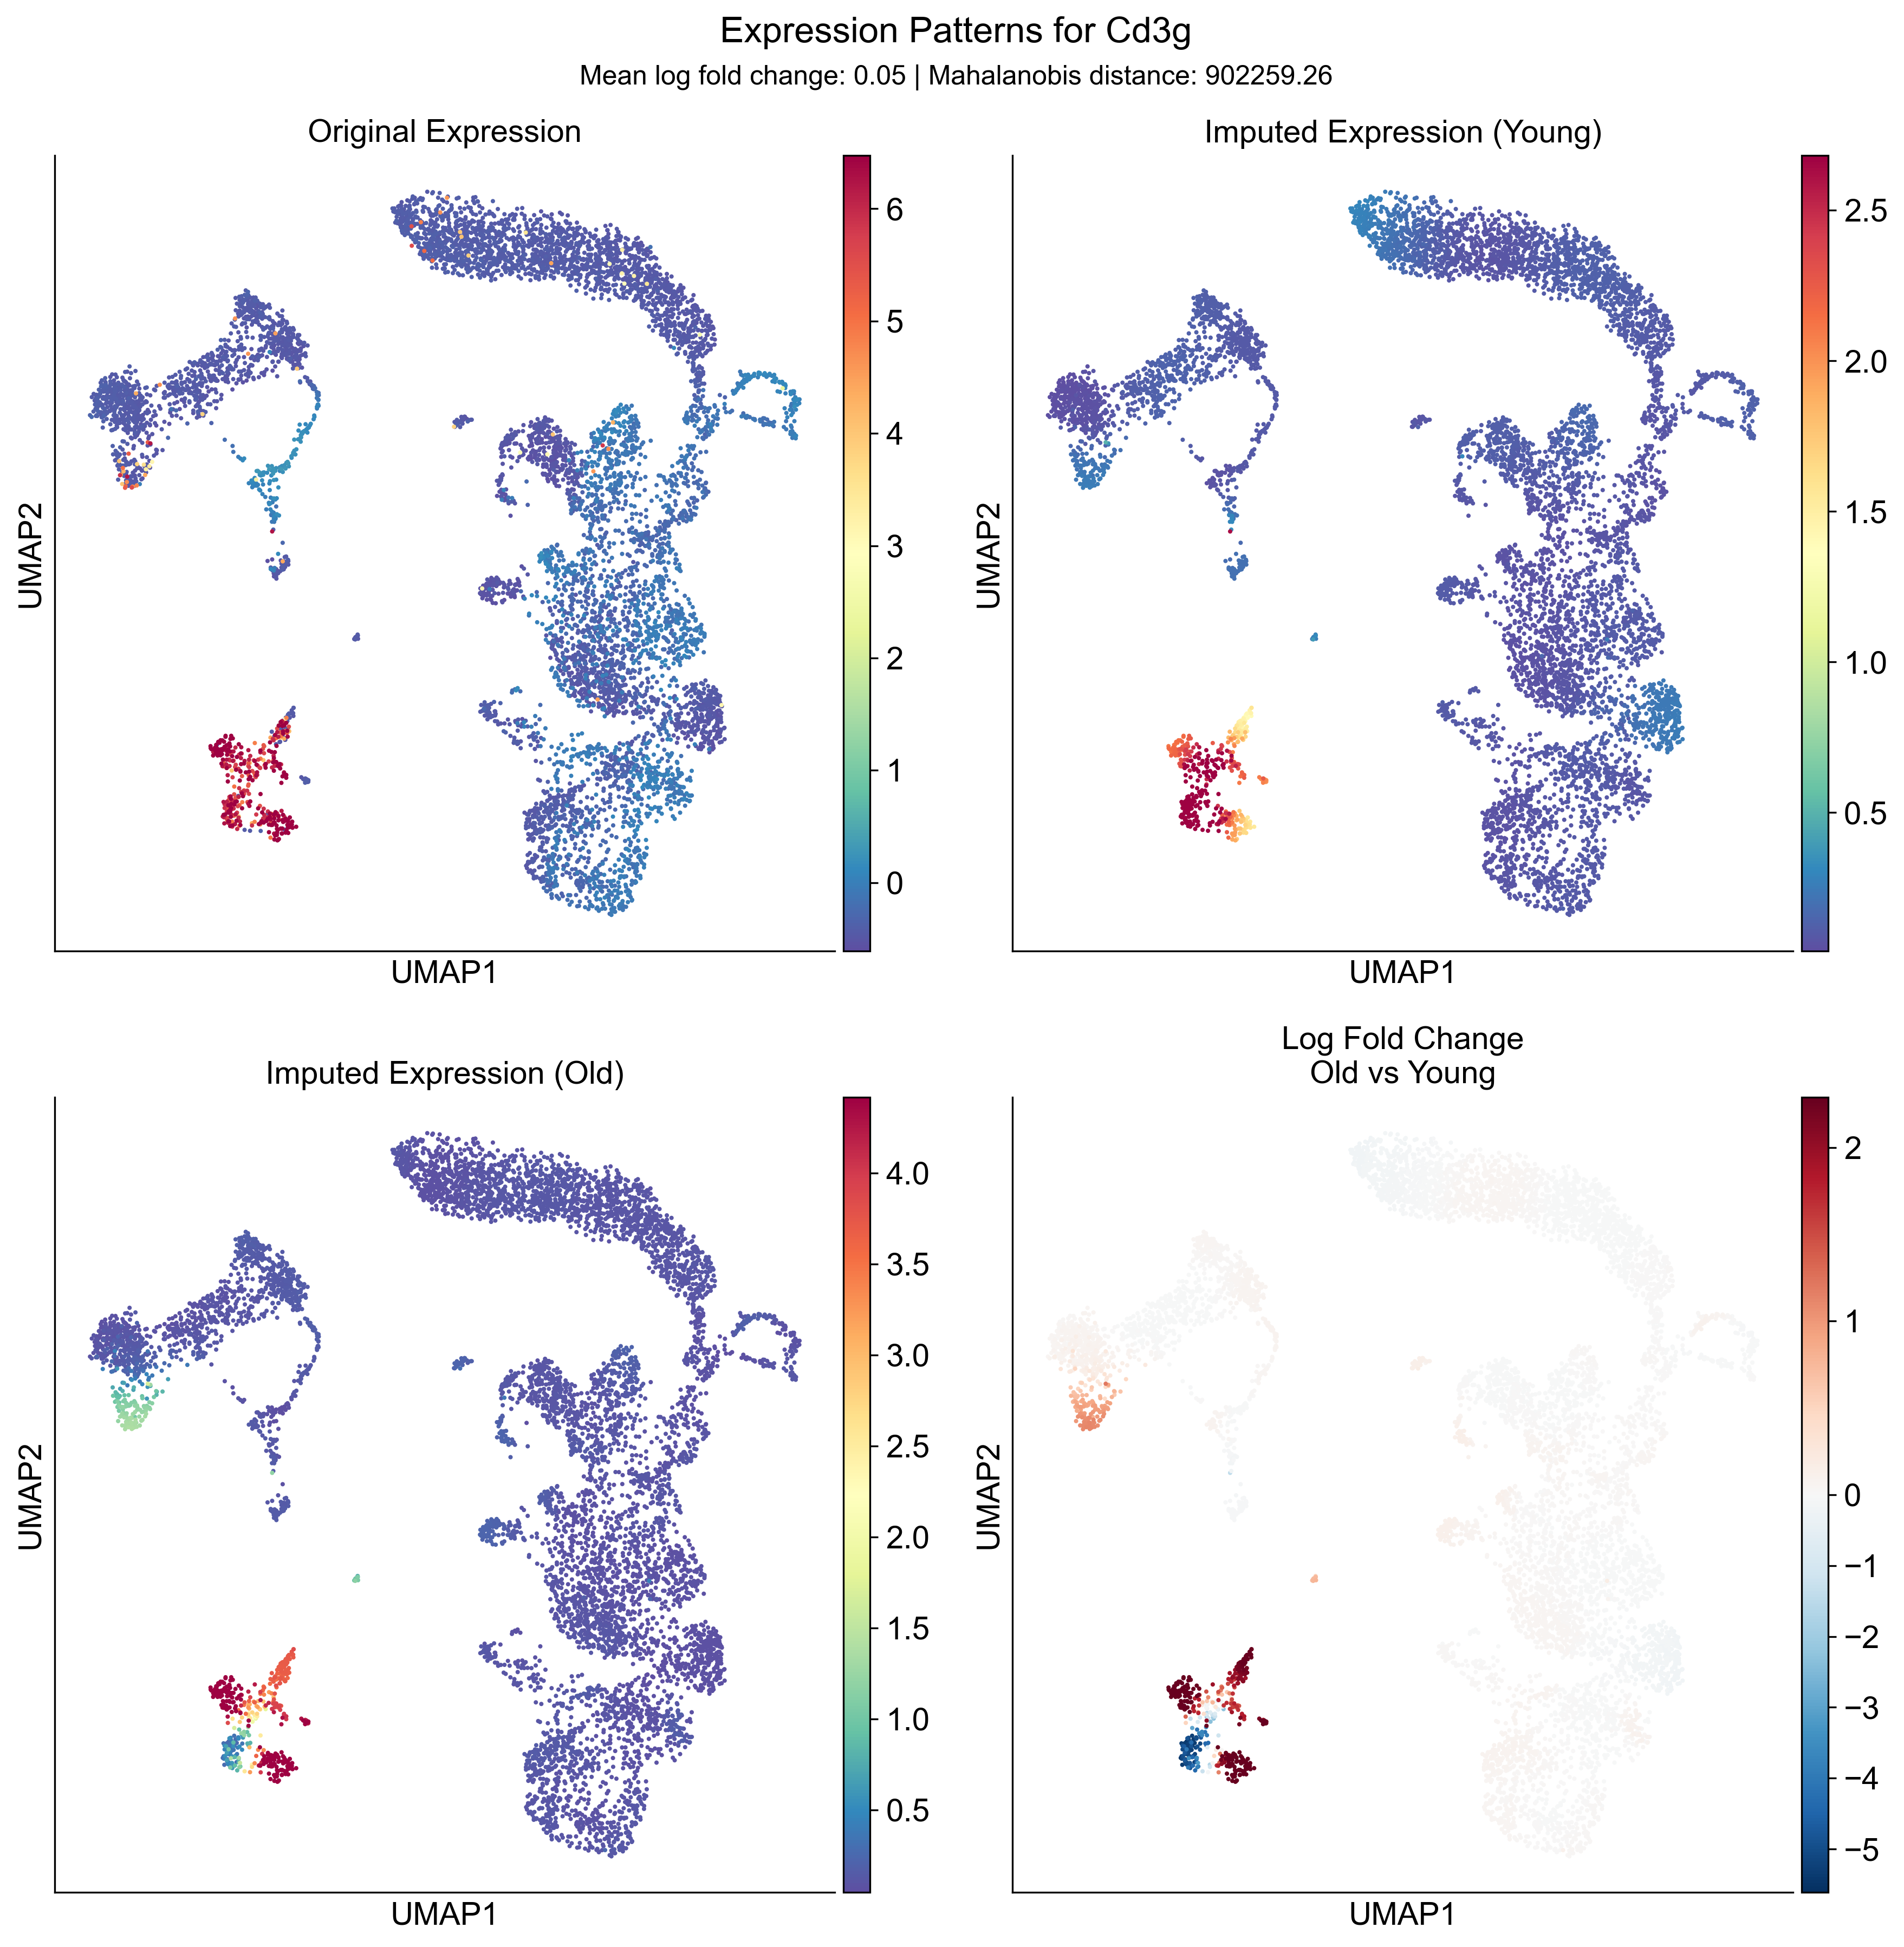

In [20]:
kompot.plot.plot_gene_expression(adata, gene="Cd3g", vmax="p98")